In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("results/inference_time.csv")
df

model                dataset  trial  inference_time  \
0     chronos_bolt_tiny    exchange_rate/short      0        0.038261   
1     chronos_bolt_tiny    exchange_rate/short      1        0.044538   
2     chronos_bolt_tiny    exchange_rate/short      2        0.038114   
3     chronos_bolt_tiny    exchange_rate/short      3        0.040268   
4     chronos_bolt_tiny    exchange_rate/short      4        0.039070   
...                 ...                    ...    ...             ...   
4135           timesfm2  jena_weather/10T/long      5       22.923797   
4136           timesfm2  jena_weather/10T/long      6       22.828293   
4137           timesfm2  jena_weather/10T/long      7       22.767915   
4138           timesfm2  jena_weather/10T/long      8       22.859948   
4139           timesfm2  jena_weather/10T/long      9       22.850802   

        domain  num_variates  prediction_length frequency  
0     Econ/Fin             1                  8         D  
1     Econ/Fin             1                  8         D  
2     Econ/Fin             1                  8         D  
3     Econ/Fin             1                  8         D  
4     Econ/Fin             1                  8         D  
...        ...           ...                ...       ...  
4135    Nature            21                720       10T  
4136    Nature            21                720       10T  
4137    Nature            21                720       10T  
4138    Nature            21                720       10T  
4139    Nature            21                720       10T  

[4140 rows x 8 columns]

In [3]:
df.columns

Index(['model', 'dataset', 'trial', 'inference_time', 'domain', 'num_variates',
       'prediction_length', 'frequency'],
      dtype='object')

In [4]:
df = df.groupby(['model', 'dataset', 'domain', 'num_variates', 'prediction_length', 'frequency']).agg({
    "inference_time": "mean",
}).reset_index()

df

model                           dataset        domain  \
0    chronos_bolt_base    bitbrains_fast_storage/5T/long  Web/CloudOps   
1    chronos_bolt_base  bitbrains_fast_storage/5T/medium  Web/CloudOps   
2    chronos_bolt_base   bitbrains_fast_storage/5T/short  Web/CloudOps   
3    chronos_bolt_base    bitbrains_fast_storage/H/short  Web/CloudOps   
4    chronos_bolt_base             bitbrains_rnd/5T/long  Web/CloudOps   
..                 ...                               ...           ...   
391           timesfm2                     solar/D/short        Energy   
392           timesfm2                      solar/H/long        Energy   
393           timesfm2                    solar/H/medium        Energy   
394           timesfm2                     solar/H/short        Energy   
395           timesfm2                     solar/W/short        Energy   

     num_variates  prediction_length frequency  inference_time  
0               2                720        5T      526.805580  
1               2                480        5T      352.916874  
2               2                 48        5T      418.579793  
3               2                 48         H       15.443538  
4               2                720        5T      205.008266  
..            ...                ...       ...             ...  
391             1                 30         D        5.433804  
392             1                720         H       33.942174  
393             1                480         H       22.742059  
394             1                 48         H       51.849244  
395             1                  8         W        3.198535  

[396 rows x 7 columns]

In [5]:
df["dataset"].unique()

array(['bitbrains_fast_storage/5T/long',
       'bitbrains_fast_storage/5T/medium',
       'bitbrains_fast_storage/5T/short',
       'bitbrains_fast_storage/H/short', 'bitbrains_rnd/5T/long',
       'bitbrains_rnd/5T/medium', 'bitbrains_rnd/5T/short',
       'bitbrains_rnd/H/short', 'bizitobs_application/10S/long',
       'bizitobs_application/10S/medium',
       'bizitobs_application/10S/short', 'bizitobs_l2c/5T/long',
       'bizitobs_l2c/5T/medium', 'bizitobs_l2c/5T/short',
       'bizitobs_l2c/H/long', 'bizitobs_l2c/H/medium',
       'bizitobs_l2c/H/short', 'bizitobs_service/10S/long',
       'bizitobs_service/10S/medium', 'bizitobs_service/10S/short',
       'dominick/long', 'dominick/medium', 'dominick/short', 'ercot/long',
       'ercot/medium', 'ercot/short', 'exchange_rate/long',
       'exchange_rate/medium', 'exchange_rate/short',
       'jena_weather/10T/long', 'jena_weather/10T/medium',
       'jena_weather/10T/short', 'jena_weather/D/short',
       'jena_weather/H/long', 

### Num. Samples + Time Series Len

In [6]:
import json
import numpy as np
from gift_eval.data import Dataset

In [7]:
datasets = pd.read_csv("results/data/dataset_pretty.csv")

In [8]:
pretty_names = {
    "jena_weather": "Jena Weather",
    "solar": "Solar",
    "bitbrains_fast_storage": "Bitbrains Fast Storage",
    "bitbrains_rnd": "Bitbrains RND",
    "bizitobs_l2c": "Bizitobs L2C",
    "bizitobs_application": "Bizitobs Application",
    "bizitobs_service": "Bizitobs Service",
}

In [9]:
short_datasets = "solar/10T solar/H solar/D solar/W jena_weather/10T jena_weather/H jena_weather/D " \
"bitbrains_fast_storage/5T bitbrains_fast_storage/H bitbrains_rnd/5T bitbrains_rnd/H bizitobs_application " \
"bizitobs_service bizitobs_l2c/5T bizitobs_l2c/H"

med_long_datasets = "solar/10T solar/H jena_weather/10T jena_weather/H " \
"bitbrains_fast_storage/5T bitbrains_rnd/5T bizitobs_application bizitobs_service bizitobs_l2c/5T bizitobs_l2c/H"

# Get union of short and med_long datasets
all_datasets = list(set(short_datasets.split() + med_long_datasets.split()))

dataset_properties_map = json.load(open("data/dataset_properties.json"))

In [10]:
def get_ts_length(ds_name, term):
    to_univariate = False  # Whether to convert the data to univariate
    dataset = Dataset(name=ds_name, term=term, to_univariate=to_univariate)

    ts_len = []
    rows = 0
    for x in dataset.test_data:
        s = x[0]["target"].shape
        if len(s) == 2:
            _, l = s
        else:
            _, l = 1, s[0]
        ts_len.append(l)
        rows += 1

    return np.average(np.array(ts_len)), rows

In [11]:
ts_len = {}
num_samples = {}

ds_name_map = {
    "bizitobs_application": "bizitobs_application/10S",
    "bizitobs_service": "bizitobs_service/10S"
}

for ds_name in all_datasets:
    for term in ["short", "medium", "long"]:
        if (
            term == "medium" or term == "long"
        ) and ds_name not in med_long_datasets.split():
            continue
        l, n = get_ts_length(ds_name, term)

        if ds_name in ["bizitobs_application", "bizitobs_service"]:
            ts_len[ds_name_map[ds_name]+"/"+term] = l
            num_samples[ds_name_map[ds_name]+"/"+term] = n
        else:
            ts_len[ds_name+"/"+term] = l
            num_samples[ds_name+"/"+term] = n

c:\Documenti\VS_Code\tesi\TSFM-ZeroShotEval\src\gift_eval\data.py:149: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  freq = norm_freq_str(to_offset(self.freq).name)
c:\Users\giuli\anaconda3\lib\site-packages\gluonts\dataset\common.py:263: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  return pd.Period(val, freq)
c:\Documenti\VS_Code\tesi\TSFM-ZeroShotEval\src\gift_eval\data.py:149: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = norm_freq_str(to_offset(self.freq).name)
c:\Users\giuli\anaconda3\lib\site-packages\gluonts\dataset\common.py:263: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.Period(val, freq)
c:\Documenti\VS_Code\tesi\TSFM-ZeroShotEval\src\gift_eval\data.py:149: FutureWarning: 'S' is deprecated and will be removed in a future version, please us

In [12]:
def get_ts_len_chronos(df):
    ts_len = []
    for e in df["target"]:
        ts_len.append(len(e))
    
    return np.average(np.array(ts_len))

In [13]:
from datasets import load_dataset

CHRONOS = "autogluon/chronos_datasets"
DATASET_CHRONOS = [
    "dominick",
    "ercot",
    "exchange_rate",
]

with open("data/chronos_dataset_properties.json") as f:
    dataset_properties_map = json.load(f)

for dataset in DATASET_CHRONOS:
    ds = load_dataset(CHRONOS, dataset, trust_remote_code=True)
    examples = [x for x in ds["train"]]
    temp_df = pd.DataFrame(examples)
    
    l = get_ts_len_chronos(temp_df)
    n = dataset_properties_map[dataset]["rows"]

    for term, c in zip(["short", "medium", "long"], [1, 10, 15]):
        ts_len[dataset+"/"+term] = l - c * dataset_properties_map[dataset]["prediction_length"]
        num_samples[dataset+"/"+term] = n

In [14]:
def add_avg_ts_len(x):
    return ts_len[x]

def add_num_samples(x):
    return num_samples[x]

df["time_series_avg_len"] = df["dataset"].apply(add_avg_ts_len)
df["num_samples"] = df["dataset"].apply(add_num_samples)
df

model                           dataset        domain  \
0    chronos_bolt_base    bitbrains_fast_storage/5T/long  Web/CloudOps   
1    chronos_bolt_base  bitbrains_fast_storage/5T/medium  Web/CloudOps   
2    chronos_bolt_base   bitbrains_fast_storage/5T/short  Web/CloudOps   
3    chronos_bolt_base    bitbrains_fast_storage/H/short  Web/CloudOps   
4    chronos_bolt_base             bitbrains_rnd/5T/long  Web/CloudOps   
..                 ...                               ...           ...   
391           timesfm2                     solar/D/short        Energy   
392           timesfm2                      solar/H/long        Energy   
393           timesfm2                    solar/H/medium        Energy   
394           timesfm2                     solar/H/short        Energy   
395           timesfm2                     solar/W/short        Energy   

     num_variates  prediction_length frequency  inference_time  \
0               2                720        5T      526.805580   
1               2                480        5T      352.916874   
2               2                 48        5T      418.579793   
3               2                 48         H       15.443538   
4               2                720        5T      205.008266   
..            ...                ...       ...             ...   
391             1                 30         D        5.433804   
392             1                720         H       33.942174   
393             1                480         H       22.742059   
394             1                 48         H       51.849244   
395             1                  8         W        3.198535   

     time_series_avg_len  num_samples  
0                 7560.0         2500  
1                 7920.0         2500  
2                 8184.0        22500  
3                  649.0         2500  
4                 7560.0         1000  
..                   ...          ...  
391                320.0          274  
392               7680.0          274  
393               8040.0          274  
394               8280.0         2603  
395                 44.0          137  

[396 rows x 9 columns]

In [15]:
df.columns

Index(['model', 'dataset', 'domain', 'num_variates', 'prediction_length',
       'frequency', 'inference_time', 'time_series_avg_len', 'num_samples'],
      dtype='object')

### Add indicators

In [16]:
df["normalized_inference_time"] = df["inference_time"] / (
    df["num_samples"] * df["prediction_length"]
)

In [17]:
df["normalized_time_per_input_output_point"] = (
    df["inference_time"] / (
        df["num_samples"] * df["prediction_length"] * df["time_series_avg_len"]
    )
)

### Pretty names

In [18]:
PRETTY_NAME ={
    "chronos_bolt_base": "Chr.B.B",
    "chronos_bolt_small": "Chr.B.S",
    "chronos_bolt_mini": "Chr.B.M",
    "chronos_bolt_tiny": "Chr.B.T",
    "timesfm1": "T.FM1",
    "timesfm2": "T.FM2",
    "moirai_small": "Moi.S",
    "moirai_base": "Moi.B",
    "moirai_large": "Moi.L",
    }

ADD_FREQ_MAP ={
    "dominick, short": "dominick, W, short",
    "dominick, medium": "dominick, W, medium",
    "dominick, long": "dominick, W, long",
    "exchange_rate, short": "exchange_rate, D, short",
    "exchange_rate, medium": "exchange_rate, D, medium",
    "exchange_rate, long": "exchange_rate, D, long",
    "ercot, short": "ercot, H, short",
    "ercot, medium": "ercot, H, medium",
    "ercot, long": "ercot, H, long",
}

In [19]:
def add_pretty_name(x):
    return PRETTY_NAME[x]

def add_pretty_dataset(x):
    x = x.replace("/", ", ")
    if x.split(", ")[0] in ["exchange_rate", "ercot", "dominick"]:
        x = ADD_FREQ_MAP[x]
    return x

df["Model"] = df["model"].apply(add_pretty_name)
df["Dataset, Frequency, Term"] = df["dataset"].apply(add_pretty_dataset)

In [20]:
# Parsing della colonna 'Dataset, Frequency, Term'
df[['dataset_name', 'frequency', 'term']] = df['Dataset, Frequency, Term'].str.split(', ', expand=True)

In [21]:
df.to_csv("results/inference_time_final.csv")

### Analisi

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

### Boxplot

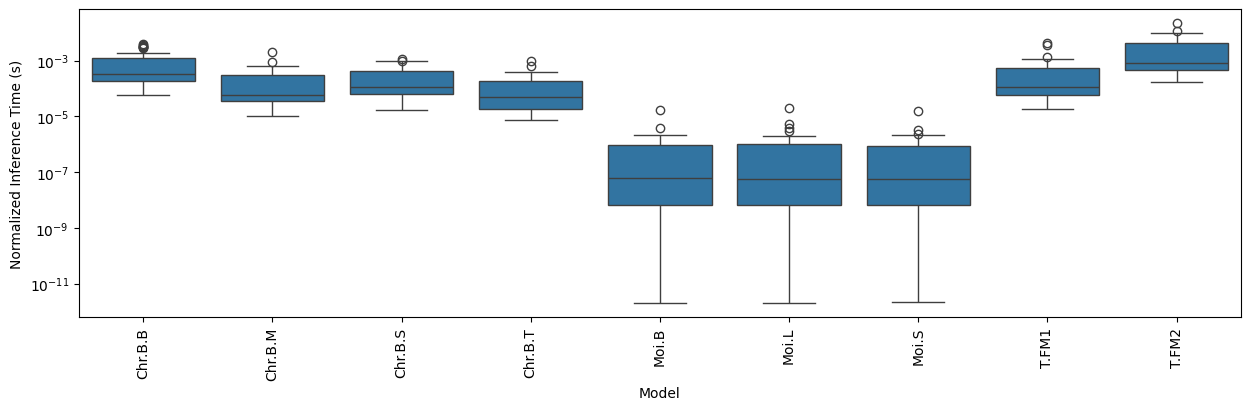

In [23]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x="Model", y="normalized_inference_time")
plt.xticks(rotation=90)
plt.ylabel("Normalized Inference Time (s)")
plt.yscale('log')
plt.show()

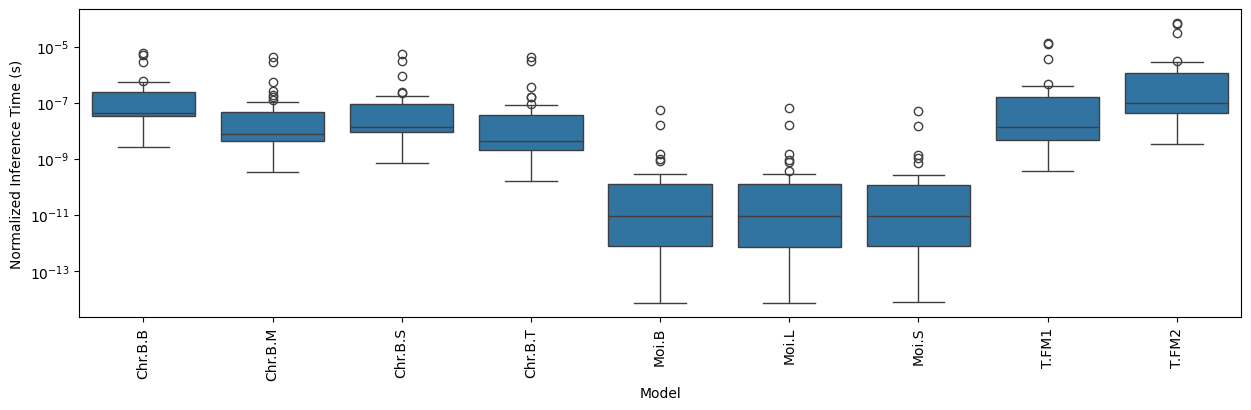

In [24]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x="Model", y="normalized_time_per_input_output_point")
plt.xticks(rotation=90)
plt.ylabel("Normalized Inference Time (s)")
plt.yscale('log')
plt.show()

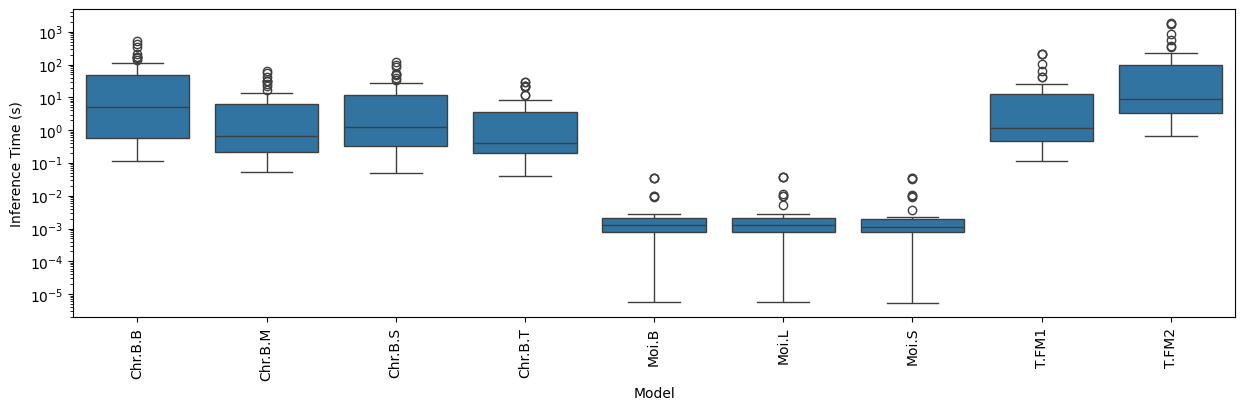

In [25]:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x="Model", y="inference_time")
plt.xticks(rotation=90)
plt.ylabel("Inference Time (s)")
plt.yscale('log')
plt.show()

#### Tables

In [26]:
ranking = df.groupby("Model")["inference_time"].mean().sort_values()
print(ranking)

Model
Moi.S        0.003918
Moi.B        0.003973
Moi.L        0.004302
Chr.B.T      4.745163
Chr.B.M      8.632092
Chr.B.S     15.754057
T.FM1       23.266848
Chr.B.B     62.077058
T.FM2      195.380173
Name: inference_time, dtype: float64


In [27]:
df_descr = df.groupby(["Model"])["inference_time"].describe()
df_descr

count        mean         std       min       25%       50%  \
Model                                                                  
Chr.B.B   44.0   62.077058  119.018577  0.113683  0.591222  5.006529   
Chr.B.M   44.0    8.632092   15.712591  0.053852  0.217192  0.678469   
Chr.B.S   44.0   15.754057   29.145007  0.050961  0.337083  1.278440   
Chr.B.T   44.0    4.745163    8.488335  0.039955  0.197271  0.398410   
Moi.B     44.0    0.003973    0.008785  0.000006  0.000780  0.001240   
Moi.L     44.0    0.004302    0.009444  0.000006  0.000763  0.001278   
Moi.S     44.0    0.003918    0.008611  0.000005  0.000774  0.001137   
T.FM1     44.0   23.266848   56.089719  0.111746  0.482523  1.146891   
T.FM2     44.0  195.380173  464.509269  0.648040  3.304450  9.023676   

               75%          max  
Model                            
Chr.B.B  47.853905   526.805580  
Chr.B.M   6.333999    63.621771  
Chr.B.S  11.437893   124.187846  
Chr.B.T   3.679251    29.391576  
Moi.B     0.002080     0.035765  
Moi.L     0.002130     0.038376  
Moi.S     0.001929     0.034859  
T.FM1    12.538156   215.736659  
T.FM2    99.797654  1815.252372

In [28]:
df_descr = df.groupby(["Model"])["inference_time"].describe()
df_descr["Ranking"] = df_descr["mean"].rank(method="min", ascending=True).astype(int)
df_descr = df_descr.sort_values("Ranking")
df_descr = df_descr.drop(columns=["count", "Ranking"])
df_descr

mean         std       min       25%       50%        75%  \
Model                                                                      
Moi.S      0.003918    0.008611  0.000005  0.000774  0.001137   0.001929   
Moi.B      0.003973    0.008785  0.000006  0.000780  0.001240   0.002080   
Moi.L      0.004302    0.009444  0.000006  0.000763  0.001278   0.002130   
Chr.B.T    4.745163    8.488335  0.039955  0.197271  0.398410   3.679251   
Chr.B.M    8.632092   15.712591  0.053852  0.217192  0.678469   6.333999   
Chr.B.S   15.754057   29.145007  0.050961  0.337083  1.278440  11.437893   
T.FM1     23.266848   56.089719  0.111746  0.482523  1.146891  12.538156   
Chr.B.B   62.077058  119.018577  0.113683  0.591222  5.006529  47.853905   
T.FM2    195.380173  464.509269  0.648040  3.304450  9.023676  99.797654   

                 max  
Model                 
Moi.S       0.034859  
Moi.B       0.035765  
Moi.L       0.038376  
Chr.B.T    29.391576  
Chr.B.M    63.621771  
Chr.B.S   124.187846  
T.FM1     215.736659  
Chr.B.B   526.805580  
T.FM2    1815.252372

In [29]:
print(df_descr.to_latex(index=True, float_format="%.6f"))

\begin{tabular}{lrrrrrrr}
\toprule
 & mean & std & min & 25% & 50% & 75% & max \\
Model &  &  &  &  &  &  &  \\
\midrule
Moi.S & 0.003918 & 0.008611 & 0.000005 & 0.000774 & 0.001137 & 0.001929 & 0.034859 \\
Moi.B & 0.003973 & 0.008785 & 0.000006 & 0.000780 & 0.001240 & 0.002080 & 0.035765 \\
Moi.L & 0.004302 & 0.009444 & 0.000006 & 0.000763 & 0.001278 & 0.002130 & 0.038376 \\
Chr.B.T & 4.745163 & 8.488335 & 0.039955 & 0.197271 & 0.398410 & 3.679251 & 29.391576 \\
Chr.B.M & 8.632092 & 15.712591 & 0.053852 & 0.217192 & 0.678469 & 6.333999 & 63.621771 \\
Chr.B.S & 15.754057 & 29.145007 & 0.050961 & 0.337083 & 1.278440 & 11.437893 & 124.187846 \\
T.FM1 & 23.266848 & 56.089719 & 0.111746 & 0.482523 & 1.146891 & 12.538156 & 215.736659 \\
Chr.B.B & 62.077058 & 119.018577 & 0.113683 & 0.591222 & 5.006529 & 47.853905 & 526.805580 \\
T.FM2 & 195.380173 & 464.509269 & 0.648040 & 3.304450 & 9.023676 & 99.797654 & 1815.252372 \\
\bottomrule
\end{tabular}



In [30]:
df.groupby(["Model"])["normalized_time_per_input_output_point"].describe()

count          mean           std           min           25%  \
Model                                                                    
Chr.B.B   44.0  4.360648e-07  1.189337e-06  2.722099e-09  3.410401e-08   
Chr.B.M   44.0  2.032504e-07  7.504995e-07  3.486919e-10  4.471521e-09   
Chr.B.S   44.0  2.558840e-07  9.349540e-07  7.012893e-10  8.842839e-09   
Chr.B.T   44.0  2.008407e-07  8.015721e-07  1.680625e-10  2.154217e-09   
Moi.B     44.0  1.685589e-09  8.340456e-09  7.223052e-15  7.874231e-13   
Moi.L     44.0  1.947639e-09  9.980187e-09  7.061943e-15  7.361307e-13   
Moi.S     44.0  1.561738e-09  7.691030e-09  7.679527e-15  7.873013e-13   
T.FM1     44.0  7.415100e-07  2.714289e-06  3.629657e-10  4.638237e-09   
T.FM2     44.0  4.289106e-06  1.460972e-05  3.369022e-09  4.264784e-08   

                  50%           75%           max  
Model                                              
Chr.B.B  4.296503e-08  2.460268e-07  5.902525e-06  
Chr.B.M  7.466545e-09  4.878956e-08  4.212464e-06  
Chr.B.S  1.331647e-08  9.331687e-08  5.442539e-06  
Chr.B.T  4.232556e-09  3.712505e-08  4.443637e-06  
Moi.B    9.539883e-12  1.252852e-10  5.354762e-08  
Moi.L    9.200600e-12  1.273636e-10  6.477162e-08  
Moi.S    8.863258e-12  1.142937e-10  4.929546e-08  
T.FM1    1.369229e-08  1.595057e-07  1.312137e-05  
T.FM2    9.856858e-08  1.192929e-06  6.777184e-05

In [31]:
pivot = df.groupby(['dataset_name', 'frequency', 'term', "Model"])["inference_time"].mean().unstack()
print(pivot.to_latex(index=True, float_format="%.6f"))

\begin{tabular}{lllrrrrrrrrr}
\toprule
 &  & Model & Chr.B.B & Chr.B.M & Chr.B.S & Chr.B.T & Moi.B & Moi.L & Moi.S & T.FM1 & T.FM2 \\
dataset_name & frequency & term &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{bitbrains_fast_storage} & \multirow[t]{3}{*}{5T} & long & 526.805580 & 63.621771 & 124.187846 & 29.391576 & 0.034362 & 0.036483 & 0.033504 & 62.838536 & 575.527537 \\
 &  & medium & 352.916874 & 43.141423 & 84.064037 & 20.483352 & 0.035765 & 0.037799 & 0.034115 & 42.858526 & 382.361930 \\
 &  & short & 418.579793 & 55.380746 & 100.698756 & 29.083142 & 0.034708 & 0.038376 & 0.034859 & 103.654161 & 864.425776 \\
\cline{2-12}
 & H & short & 15.443538 & 3.794846 & 5.338827 & 2.885971 & 0.002741 & 0.002734 & 0.003777 & 12.322267 & 92.706562 \\
\cline{1-12} \cline{2-12}
\multirow[t]{4}{*}{bitbrains_rnd} & \multirow[t]{3}{*}{5T} & long & 205.008266 & 25.212700 & 49.874878 & 11.709211 & 0.009906 & 0.010099 & 0.009757 & 25.283995 & 232.783936 \\
 &  & medium & 137.776266 & 1

#### Heatmap

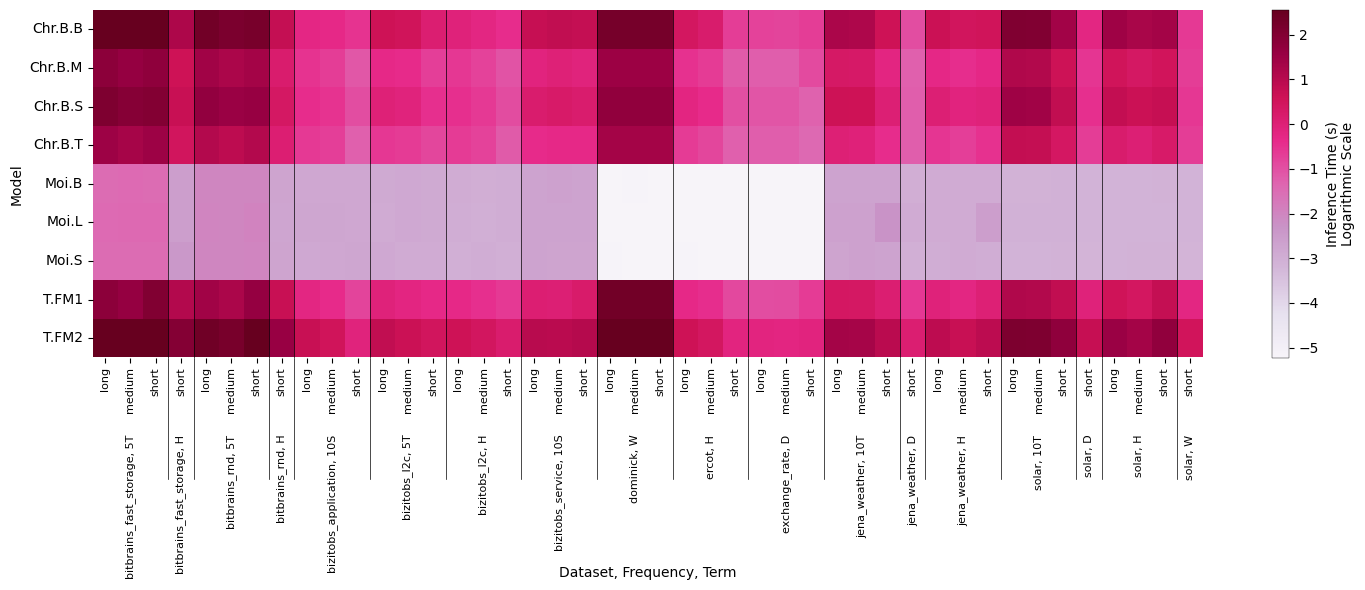

In [32]:
pivot = df.groupby(['dataset_name', 'frequency', 'term', "Model"])["inference_time"].mean().unstack()
pivot_log = np.log10(pivot + 1e-9)
pivot_log = pivot_log.sort_index(level=[0, 1, 2])

plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_log.T, cmap="PuRd", annot=False, robust=True)

# x-axis labels
x_labels = [f"{t}" for (_, f, t) in pivot_log.index]
x = np.arange(len(x_labels)) + 0.5
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=90, fontsize=8)

from collections import defaultdict
group_map = defaultdict(list)
for i, (d, f, _) in enumerate(pivot_log.index):
    group_map[(d, f)].append(i)

# labels
for (d, f), indices in group_map.items():
    center = np.mean(indices) + 0.5
    ax.text(center, ax.get_ylim()[0]+2, f"{d}, {f}",
        ha='center', va='top', fontsize=8, rotation=90, clip_on=False)

positions = []
last = None
for i, (ds, f, _) in enumerate(pivot_log.index):
    if (ds, f) != last and last is not None:
        positions.append(i)
    last = (ds, f)
for pos in positions:
    ax.axvline(pos, color='black', linewidth=0.5)
    ax.plot([pos, pos], [0, -0.35], transform=ax.get_xaxis_transform(), color='black', linewidth=0.5, clip_on=False)

# Colorbar
cbar = ax.collections[0].colorbar
cbar.set_label("Inference Time (s)\nLogarithmic Scale")
for spine in cbar.ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.3)

plt.subplots_adjust(bottom=0.3)
plt.xlabel("Dataset, Frequency, Term", labelpad=110)

plt.tight_layout()
plt.savefig("figures/inference_time_heatmap.pdf")
plt.show()

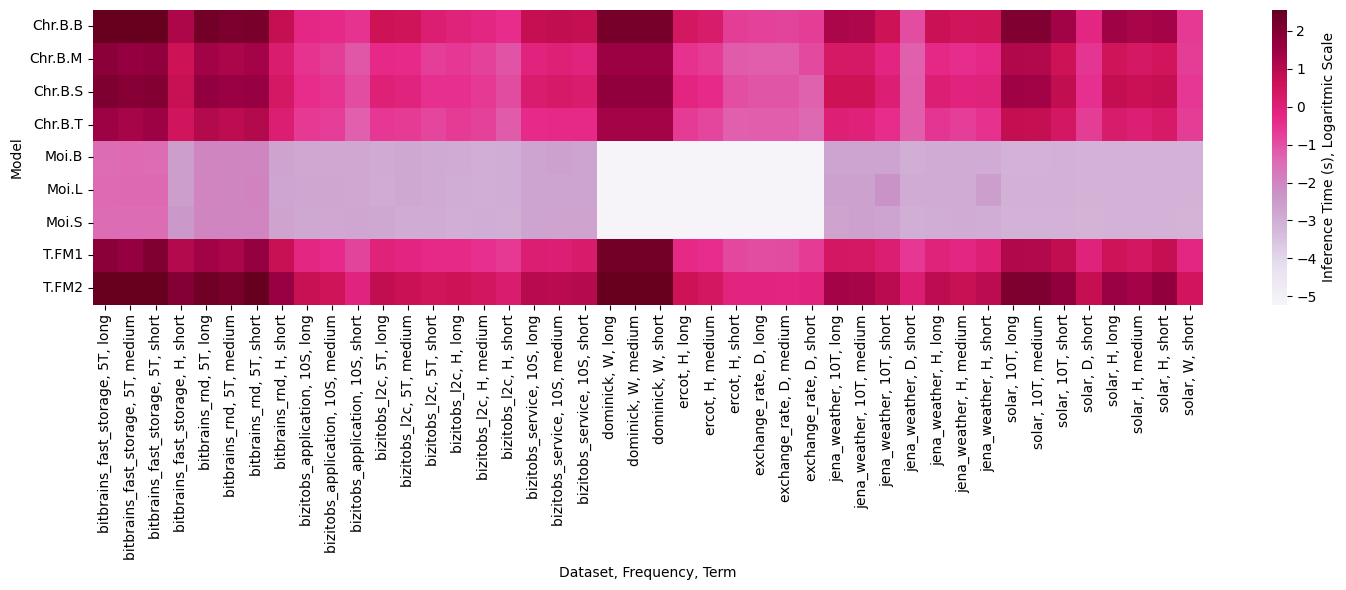

In [33]:
pivot = df.groupby(["Dataset, Frequency, Term", "Model"])["inference_time"].mean().unstack()
pivot_log = np.log10(pivot + 1e-9)

plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_log.T, cmap="PuRd", annot=False, robust=True)

cbar = ax.collections[0].colorbar
cbar.set_label("Inference Time (s), Logaritmic Scale")

plt.tight_layout()
plt.show()

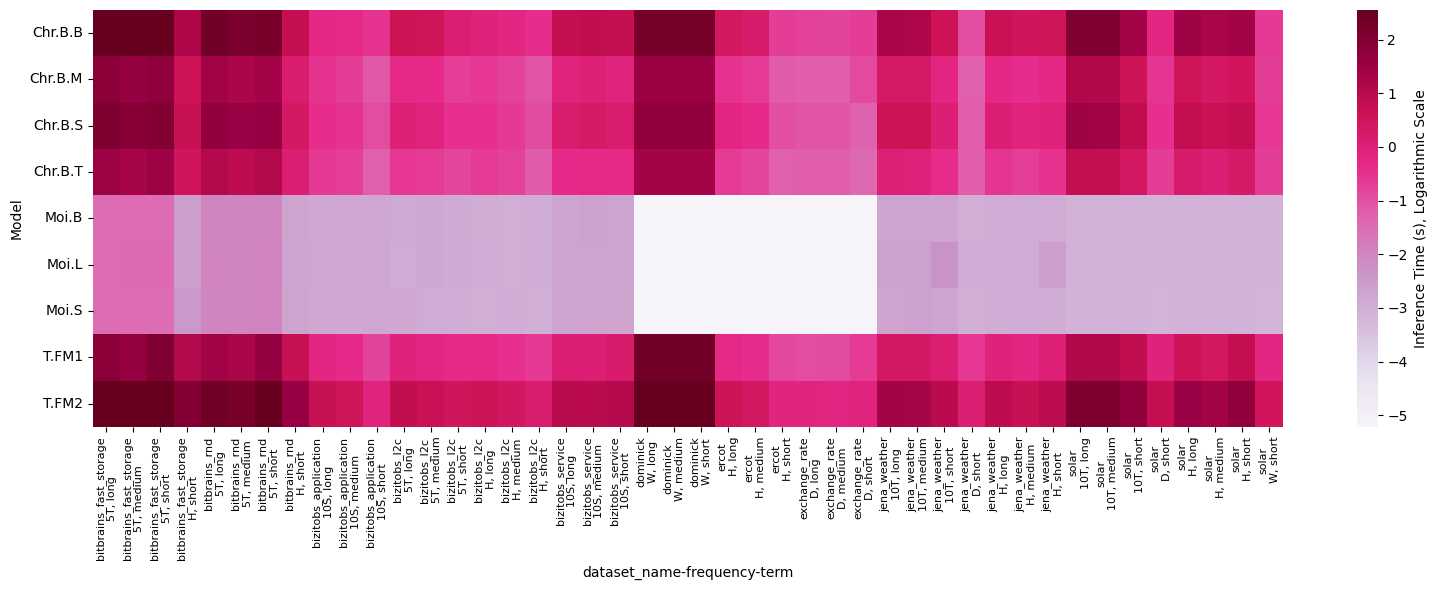

In [34]:
pivot = df.groupby(["dataset_name", "frequency", "term", "Model"])["inference_time"].mean().unstack()
pivot_log = np.log10(pivot + 1e-9)

pivot_log = pivot_log.sort_index(level=[0,1,2])

# Plot
plt.figure(figsize=(16, 6))
ax = sns.heatmap(pivot_log.T, cmap="PuRd", annot=False, robust=True)

x_labels = [
    f"{d}\n{f}, {t}" for d, f, t in pivot_log.index
]
ax.set_xticks(np.arange(len(x_labels)) + 0.5)
ax.set_xticklabels(x_labels, rotation=90, fontsize=8)

# Colorbar label
cbar = ax.collections[0].colorbar
cbar.set_label("Inference Time (s), Logarithmic Scale")

plt.tight_layout()
plt.show()


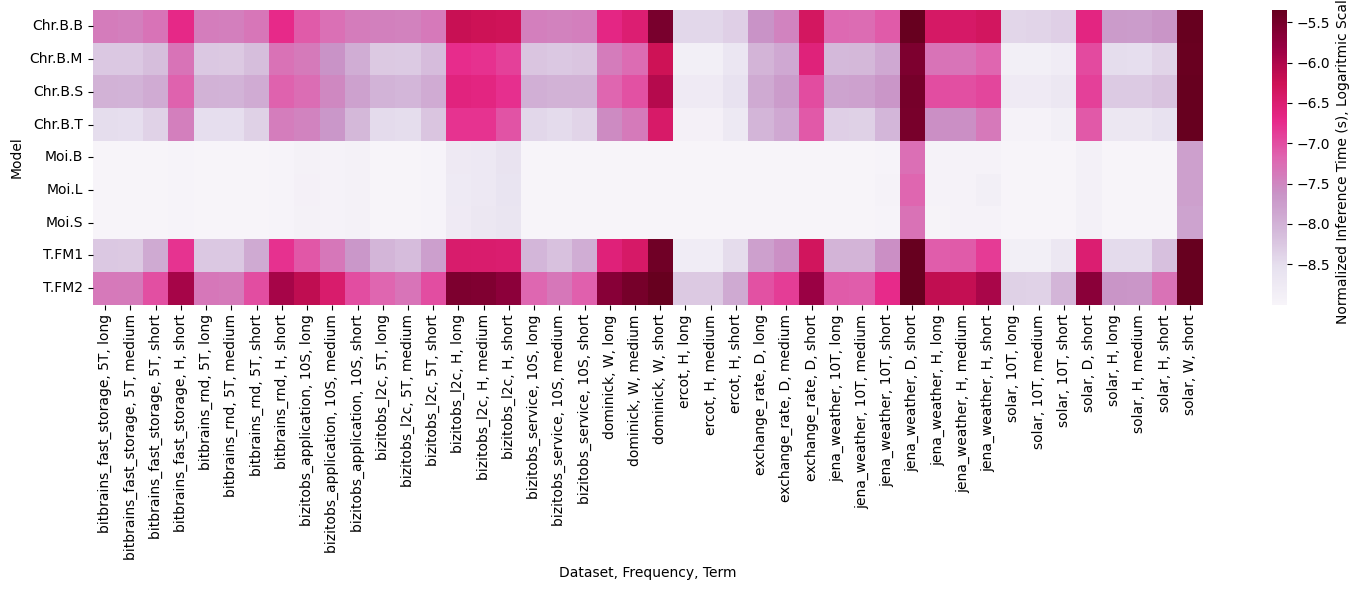

In [35]:
pivot = df.groupby(["Dataset, Frequency, Term", "Model"])["normalized_time_per_input_output_point"].mean().unstack()
pivot_log = np.log10(pivot + 1e-9)

plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot_log.T, cmap="PuRd", annot=False, robust=True)

# Aggiungi label alla colorbar in modo alternativo
cbar = ax.collections[0].colorbar
cbar.set_label("Normalized Inference Time (s), Logaritmic Scale")

plt.tight_layout()
plt.show()

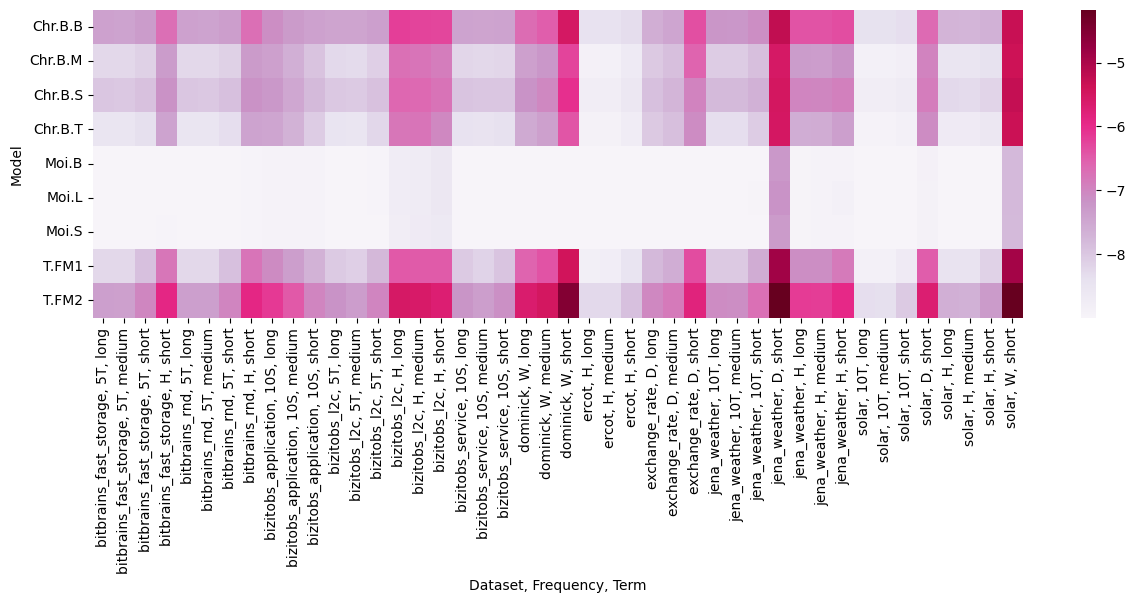

In [36]:
pivot = df.groupby(["Dataset, Frequency, Term", "Model"])["normalized_time_per_input_output_point"].mean().unstack()
pivot_log = np.log10(pivot + 1e-9)

plt.figure(figsize=(15, 4))
sns.heatmap(pivot_log.T, cmap="PuRd", annot=False); # cmap="Pastel1"

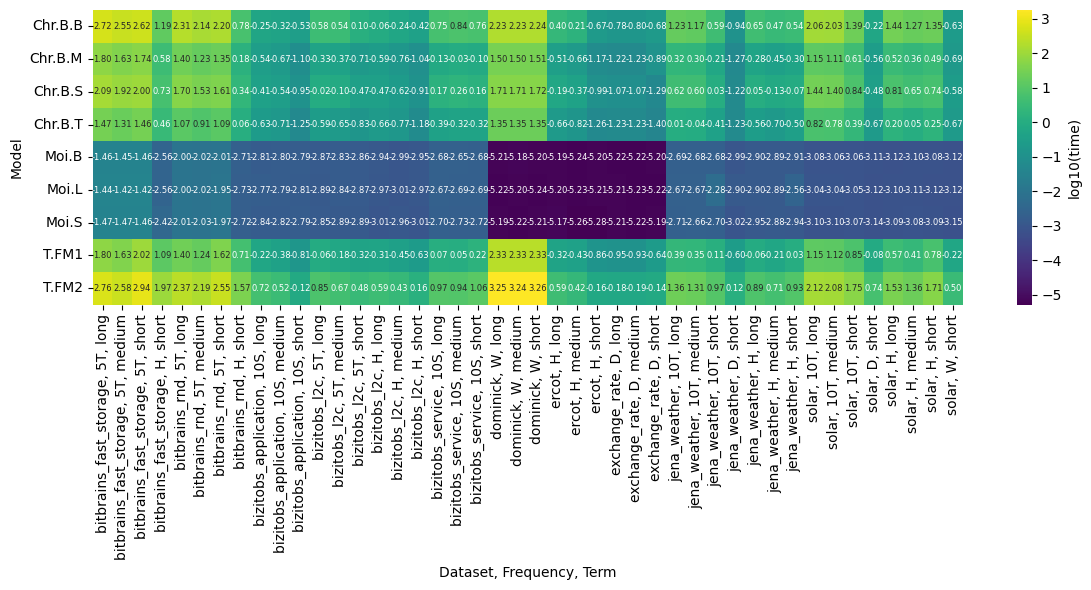

In [37]:
pivot = df.pivot_table(
    values="inference_time",
    index="Model",
    columns="Dataset, Frequency, Term",
    aggfunc="mean"
)

pivot_log = np.log10(pivot + 1e-9)  # evita log(0)

# Plot
plt.figure(figsize=(12, 6))
ax = sns.heatmap(pivot_log, cmap="viridis", annot=True, annot_kws={"size": 6}, fmt=".2f", cbar_kws={"label": "log10(time)"})

plt.tight_layout()
plt.show()

#### Barplot

In [38]:
MODEL_NAME = {
    'Chr.B.B': "Choronos Bolt (Base)",
    'Chr.B.M': "Choronos Bolt (Mini)",
    'Chr.B.S': "Choronos Bolt (Small)",
    'Chr.B.T': "Choronos Bolt (Tiny)",
    'Moi.B': "Moirai (Base)",
    'Moi.L': "Moirai (Large)",
    'Moi.S': "Moirai (Small)",
    'T.FM1': "TimesFM-1.0",
    'T.FM2': "TimesFM-2.0",
}

models = df['Model'].unique()

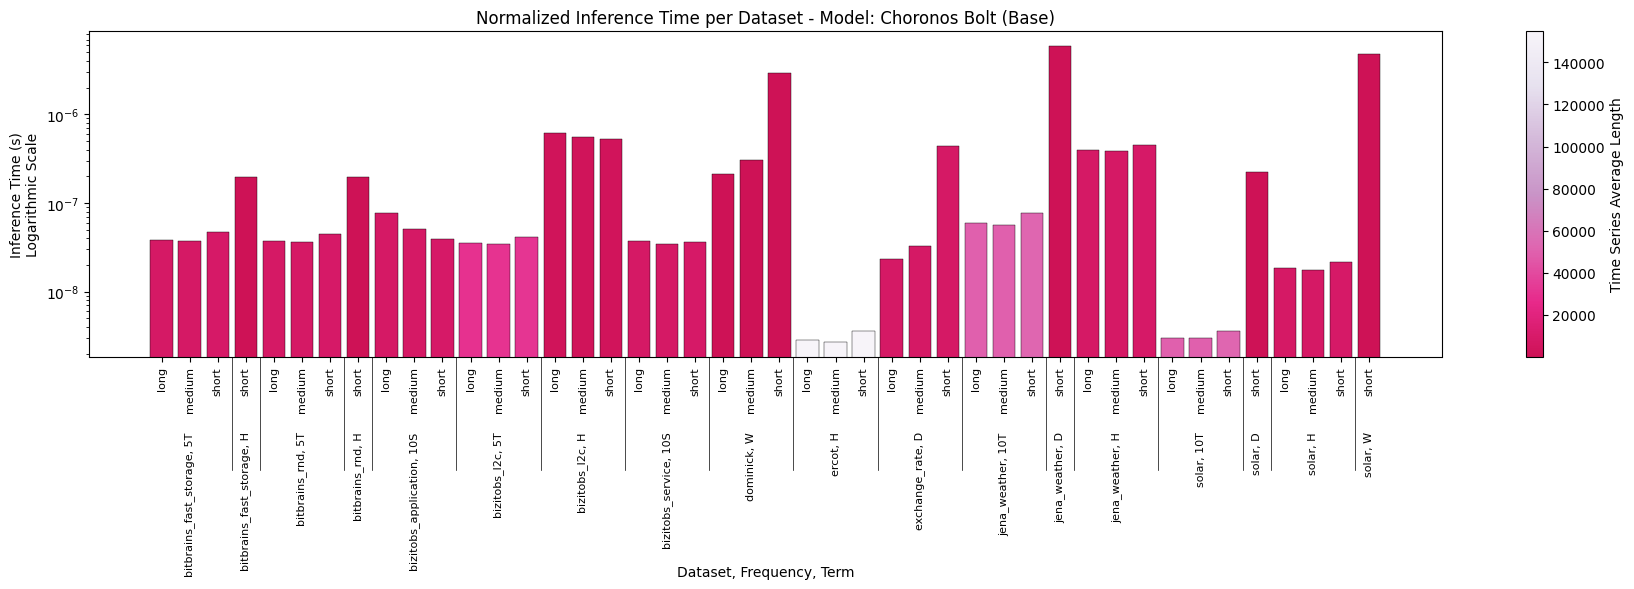

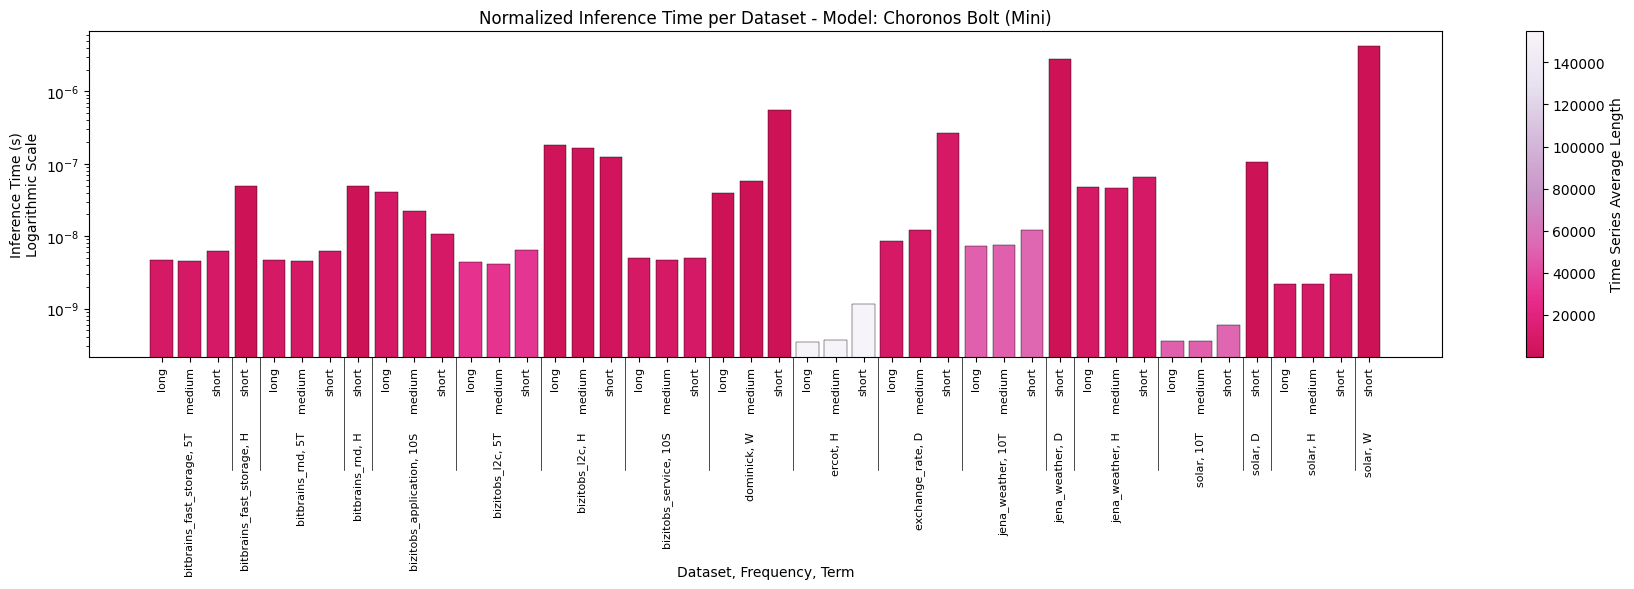

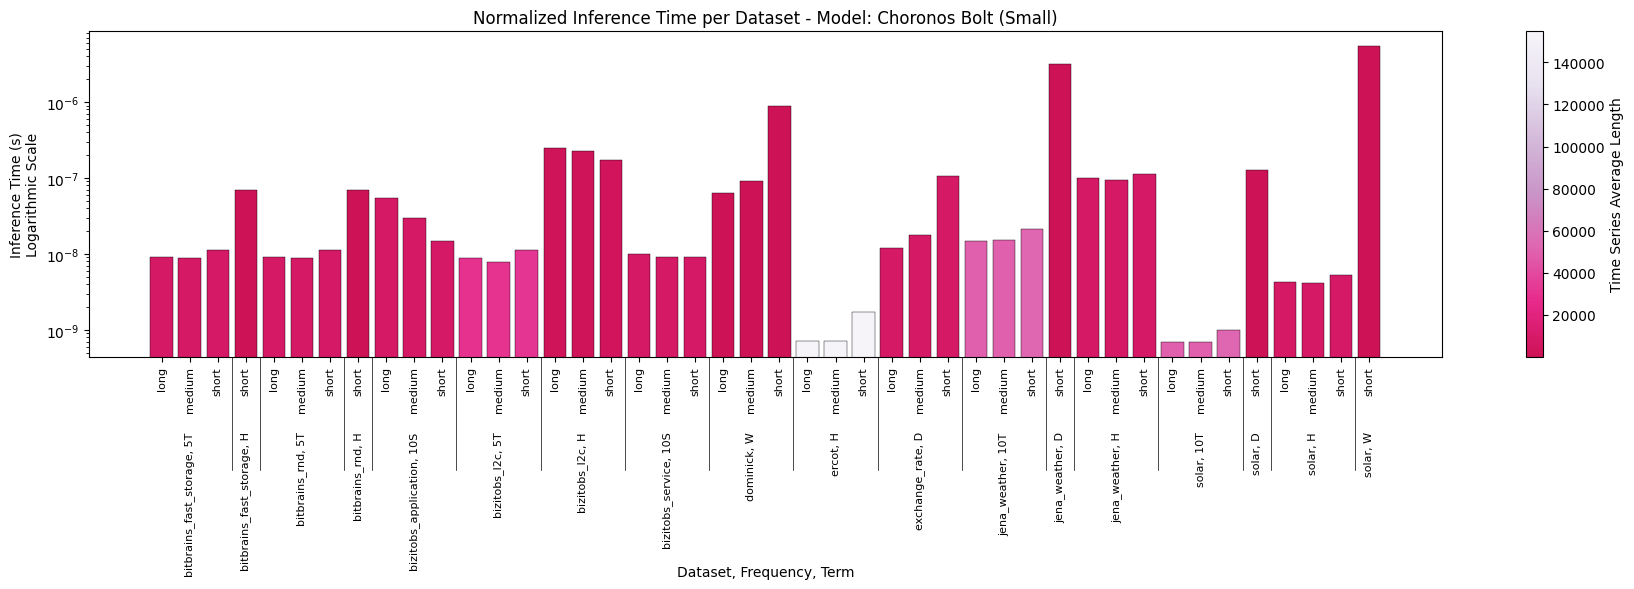

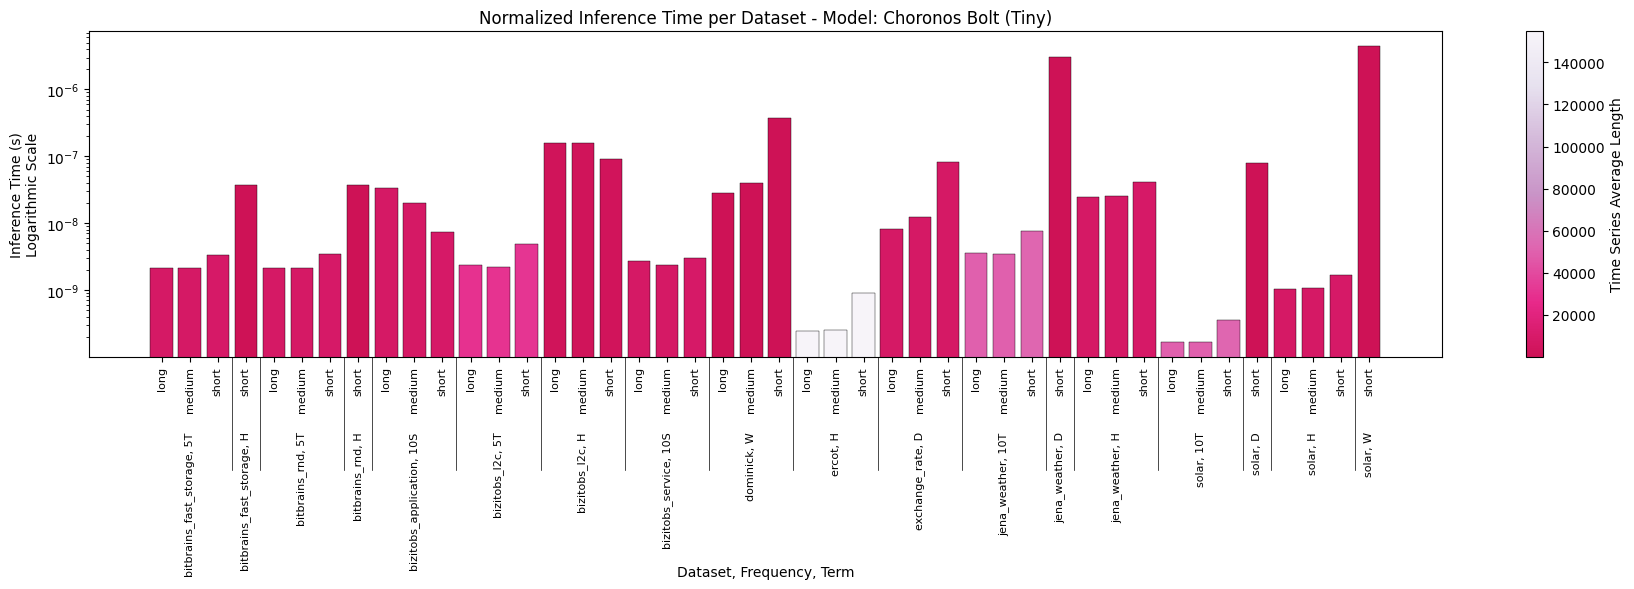

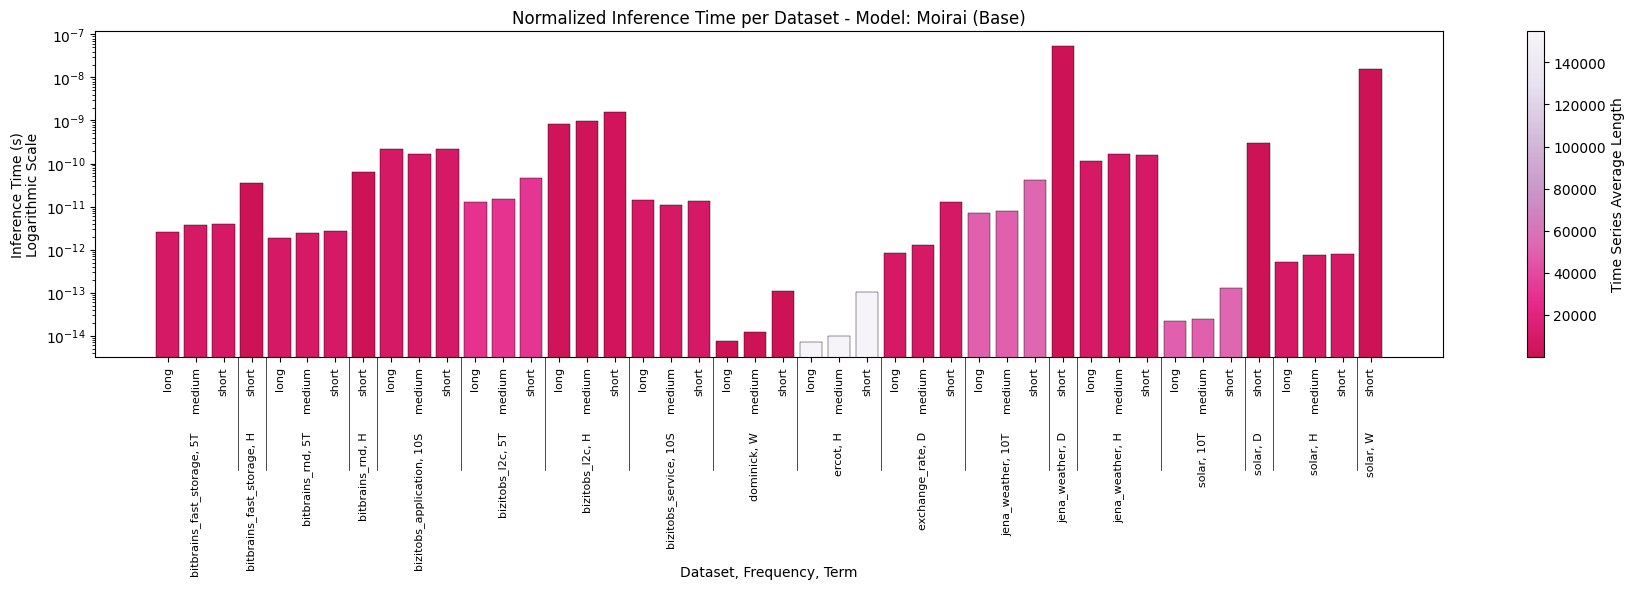

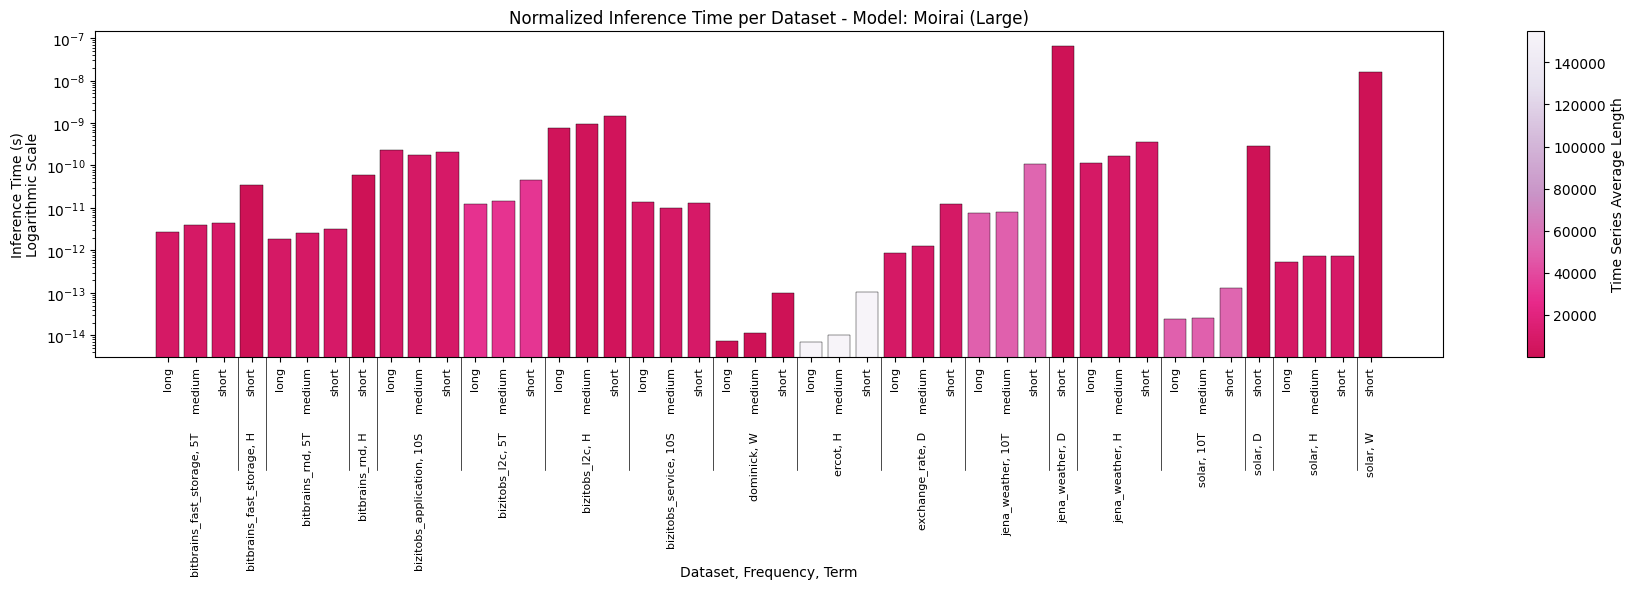

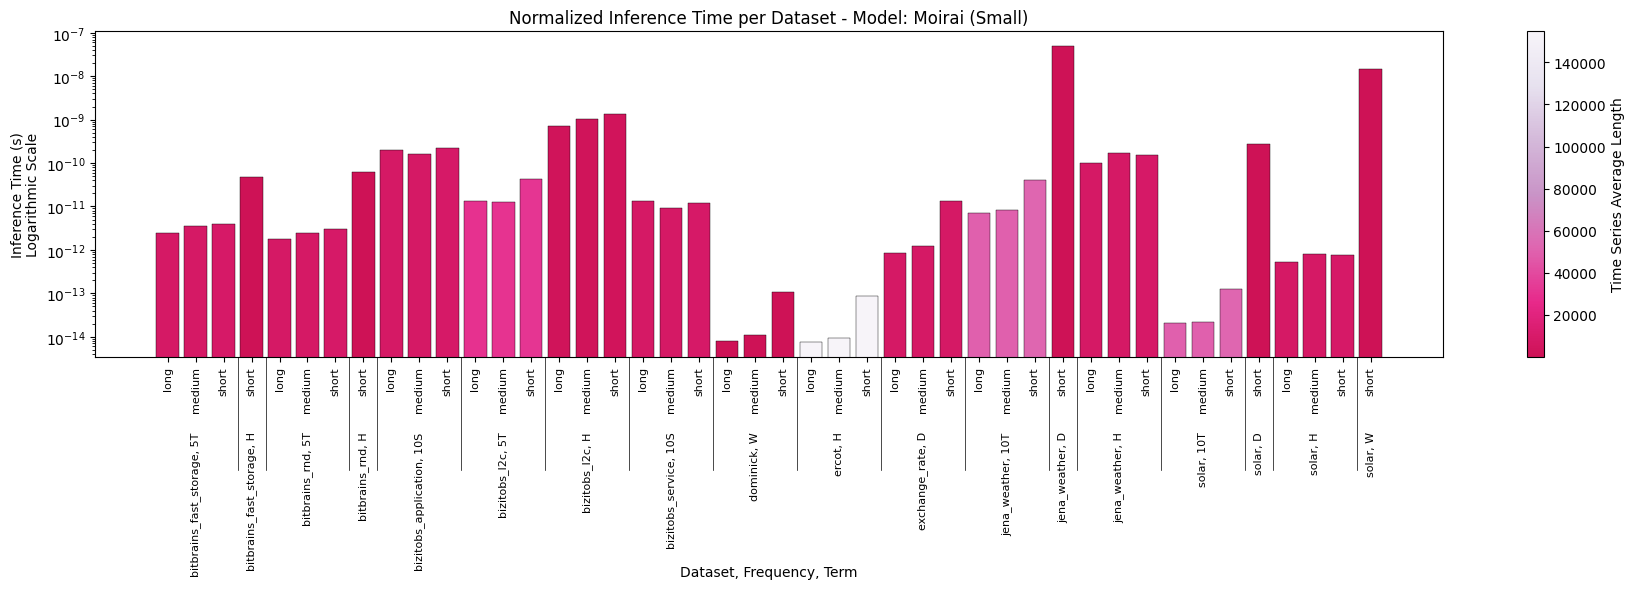

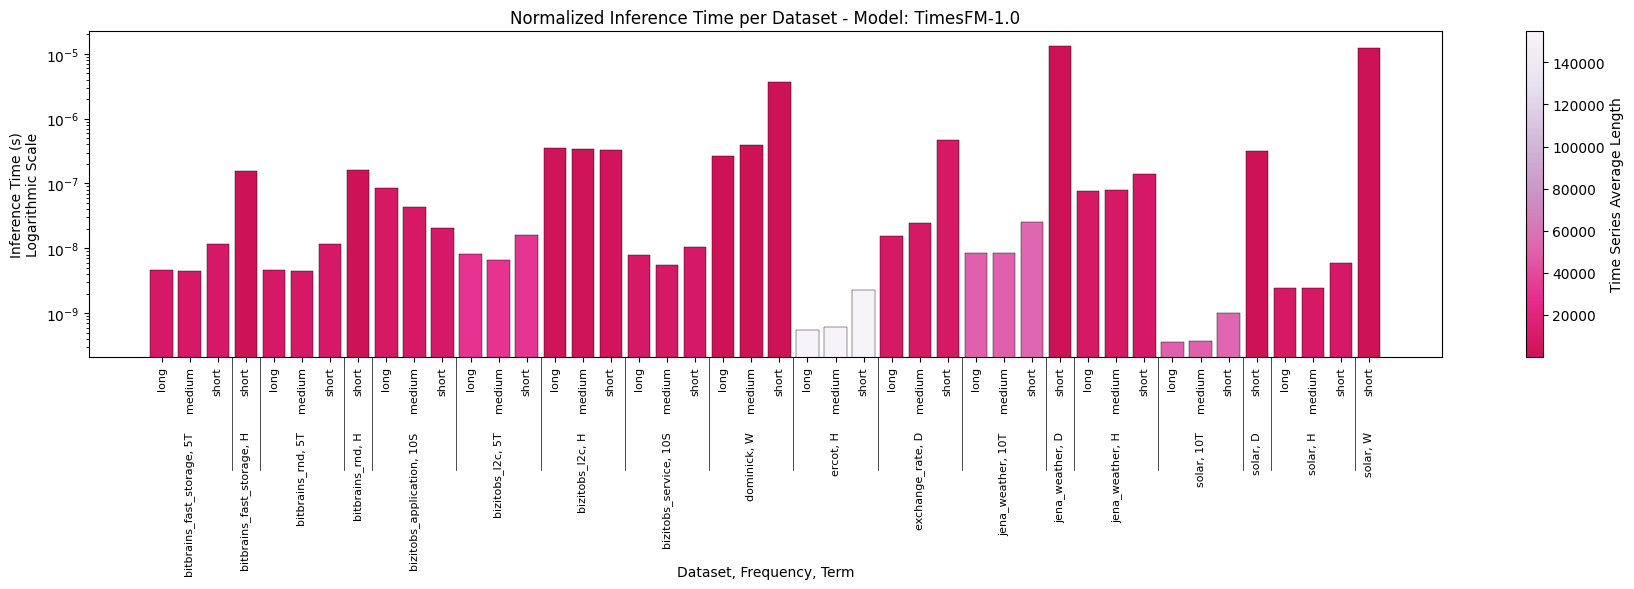

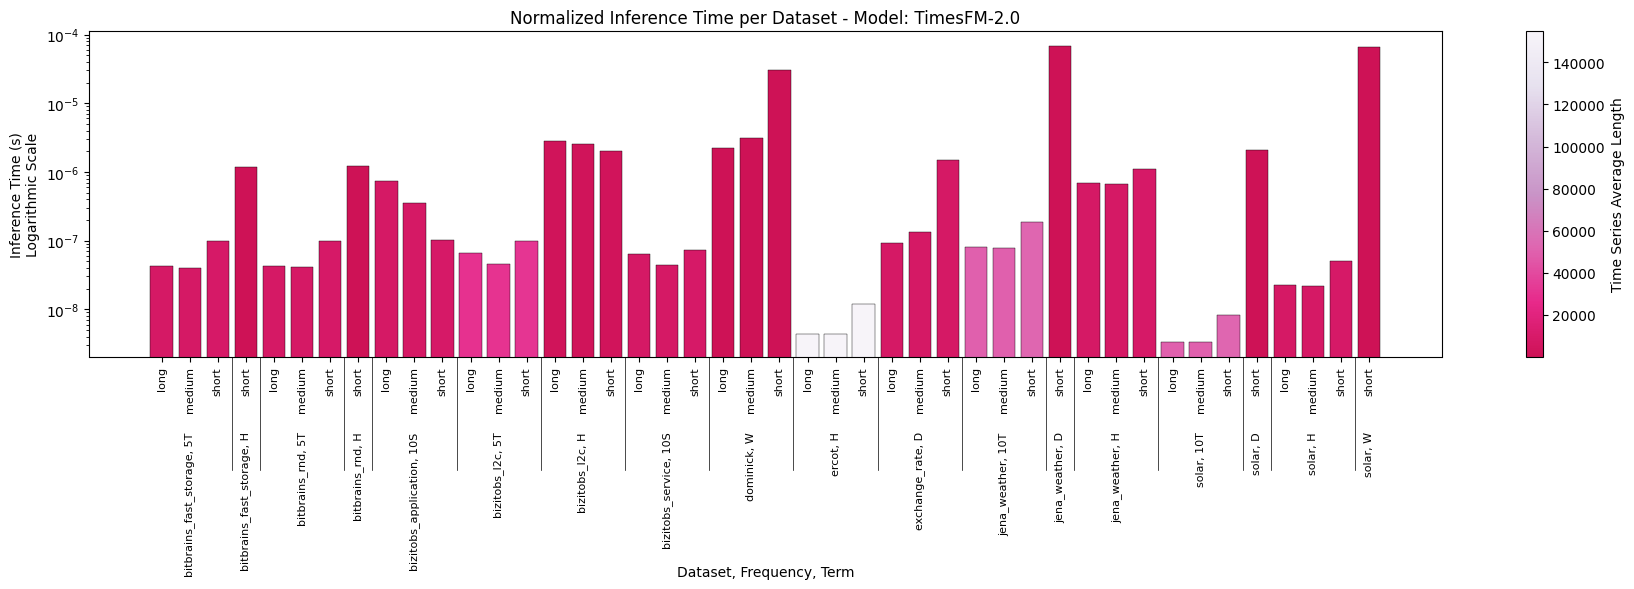

In [39]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

for model in models:
    sub_df = df[df['Model'] == model].copy().reset_index()

    sub_df = sub_df.sort_values(["dataset_name", "frequency", "term"])
    x = np.arange(len(sub_df))

    fig, ax = plt.subplots(figsize=(18, 6))

    norm = plt.Normalize(sub_df["time_series_avg_len"].min(), sub_df["time_series_avg_len"].max())
    #cmap = plt.cm.PuRd.reversed()
    cmap = ListedColormap(plt.get_cmap(plt.cm.PuRd.reversed(), 5000)(np.linspace(0.25, 1, 5000)))
    colors = cmap(norm(sub_df["time_series_avg_len"]))

    bars = ax.bar(
        x,
        sub_df["normalized_time_per_input_output_point"],
        color=colors,
        edgecolor='black',
        linewidth=0.3
    )

    ax.set_xticks(x)
    ax.set_xticklabels(sub_df["term"], rotation=90, fontsize=8)

    ax.set_yscale("log")
    ax.set_ylabel("Inference Time (s)\nLogarithmic Scale")
    ax.set_title(f"Normalized Inference Time per Dataset - Model: {MODEL_NAME[model]}")

    group_map = defaultdict(list)
    for i, row in sub_df.iterrows():
        group_map[(row["dataset_name"], row["frequency"])].append(i)

    # labels
    for (d, f), indices in group_map.items():
        center = np.mean(indices)
        ax.text(center, -0.23, f"{d}, {f}", ha='center', va='top', rotation=90,
                fontsize=8, transform=ax.get_xaxis_transform(), clip_on=False)

    positions = []
    last = None
    for i, row in sub_df.iterrows():
        current = (row["dataset_name"], row["frequency"])
        if current != last and last is not None:
            positions.append(i)
        last = current

    for pos in positions:
        ax.plot([pos - 0.5, pos - 0.5], [0, -0.35], transform=ax.get_xaxis_transform(),
                color='black', linewidth=0.5, clip_on=False)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Time Series Average Length")

    plt.subplots_adjust(bottom=0.35)
    plt.xlabel("Dataset, Frequency, Term", labelpad=110)

    plt.tight_layout()
    model_save_name = sub_df["model"][0]
    plt.savefig(f"figures/barplot_inference_time_{model_save_name}.pdf")
    plt.show()

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


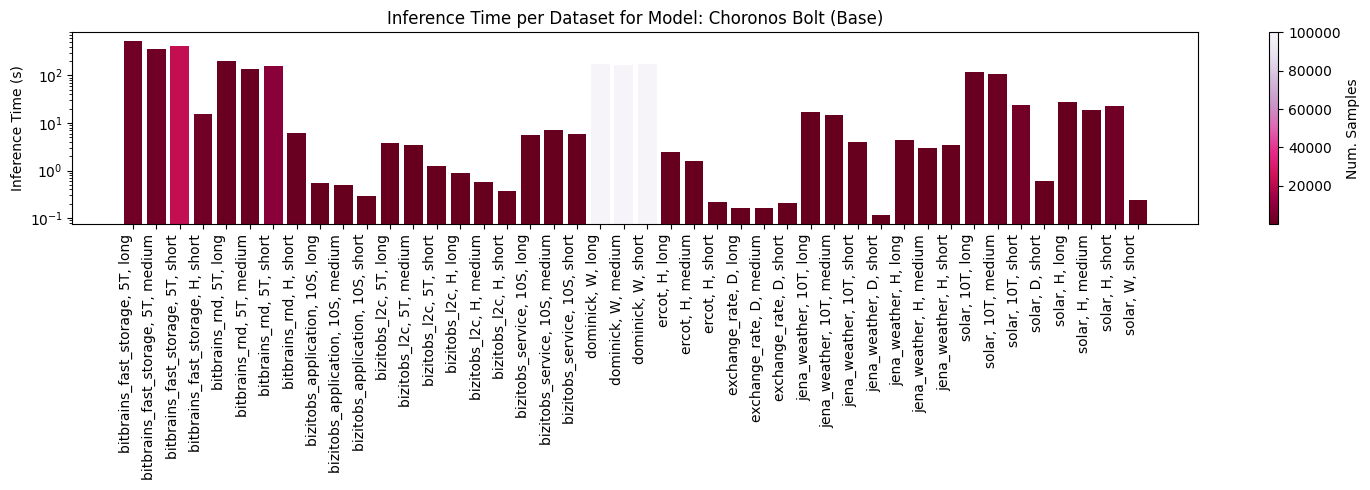

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


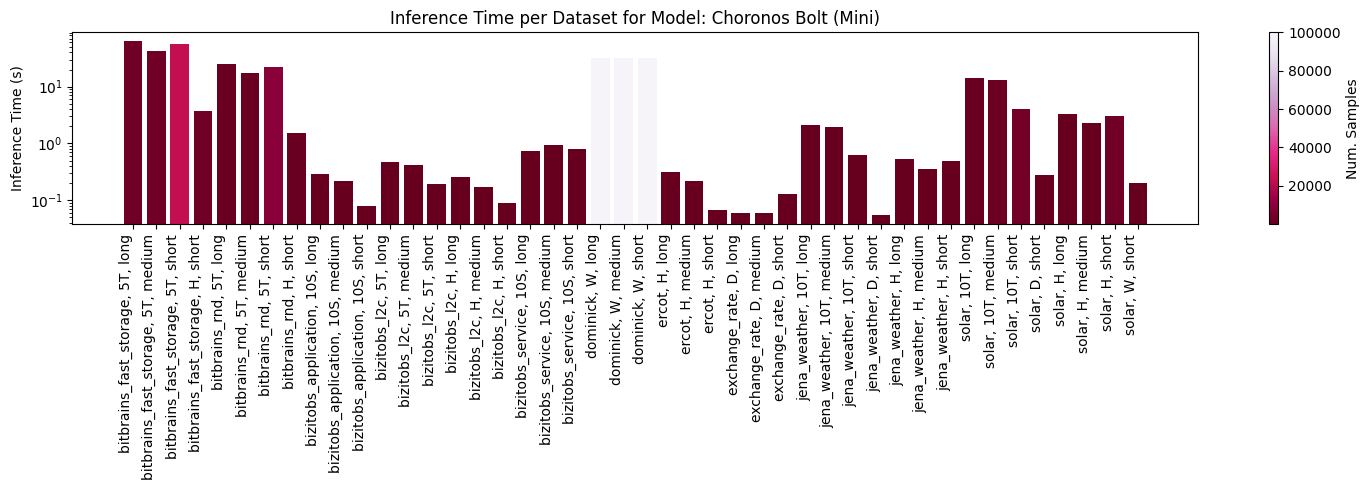

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


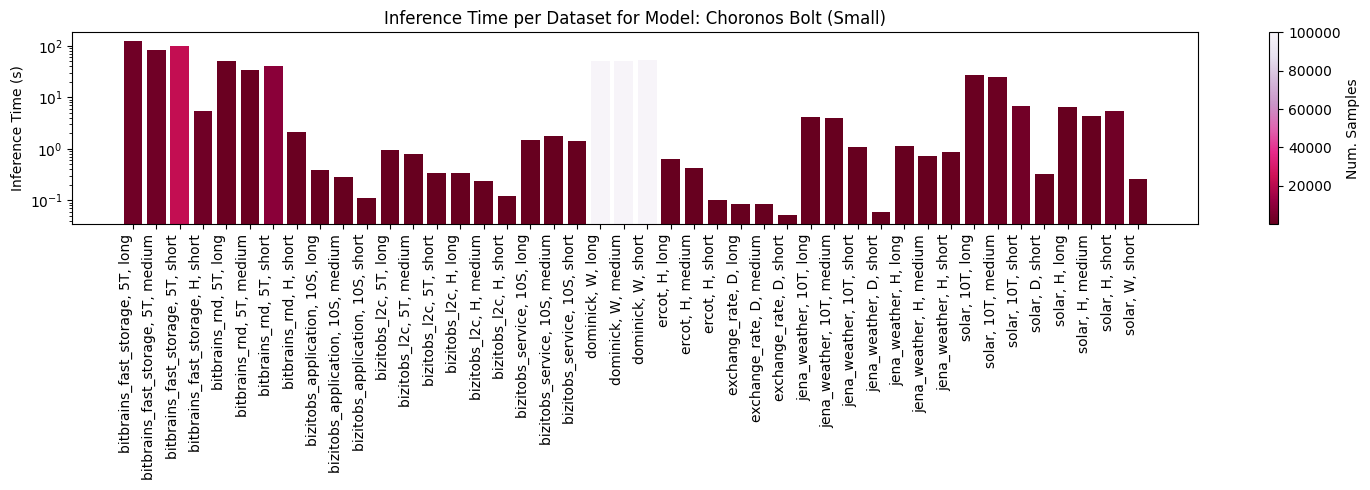

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


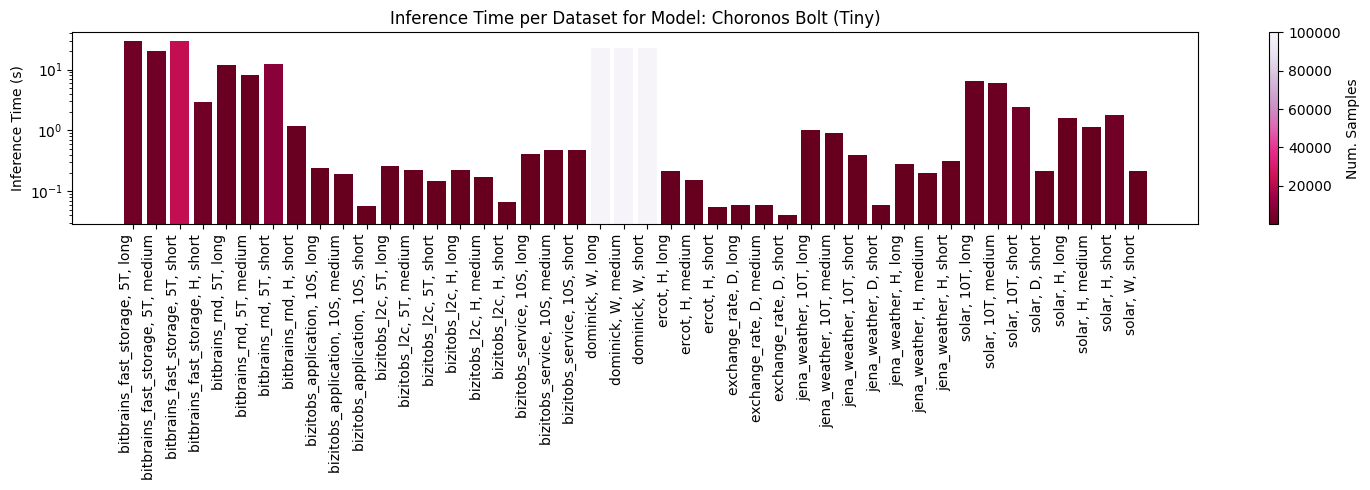

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


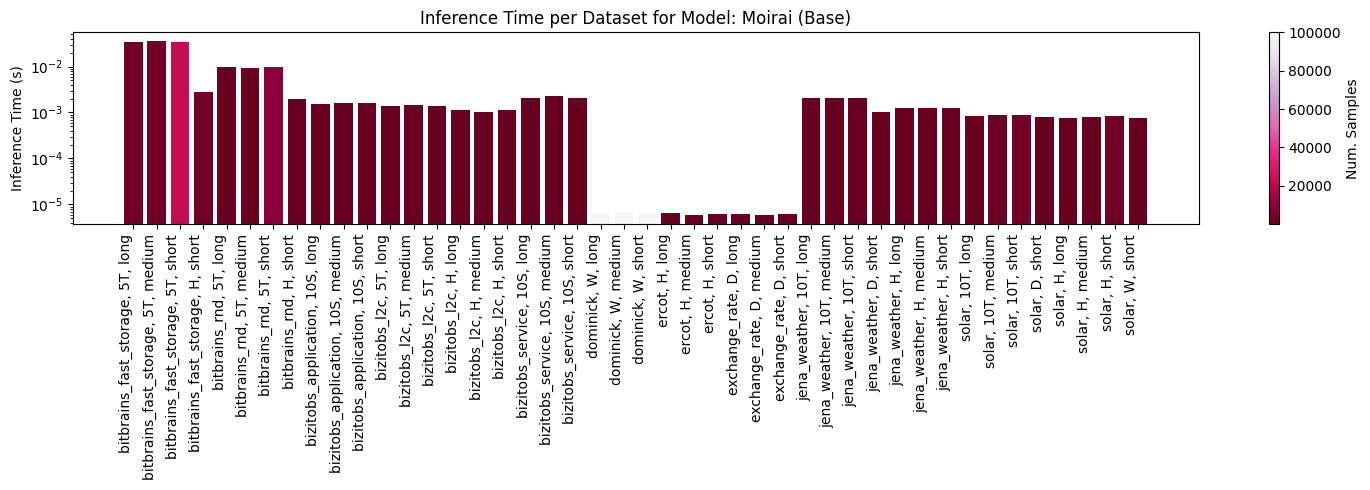

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


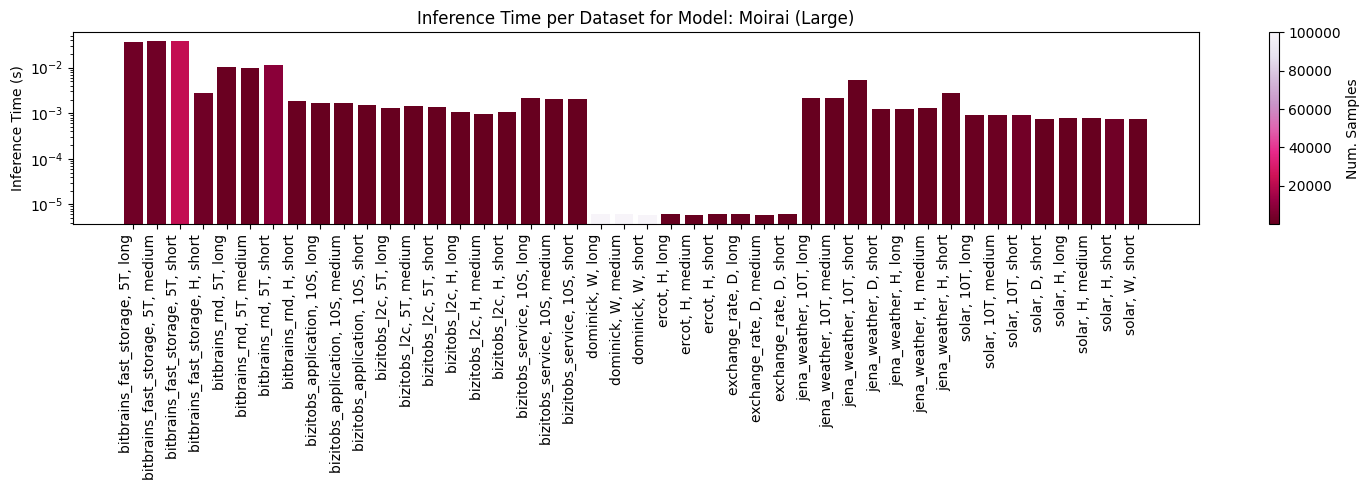

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


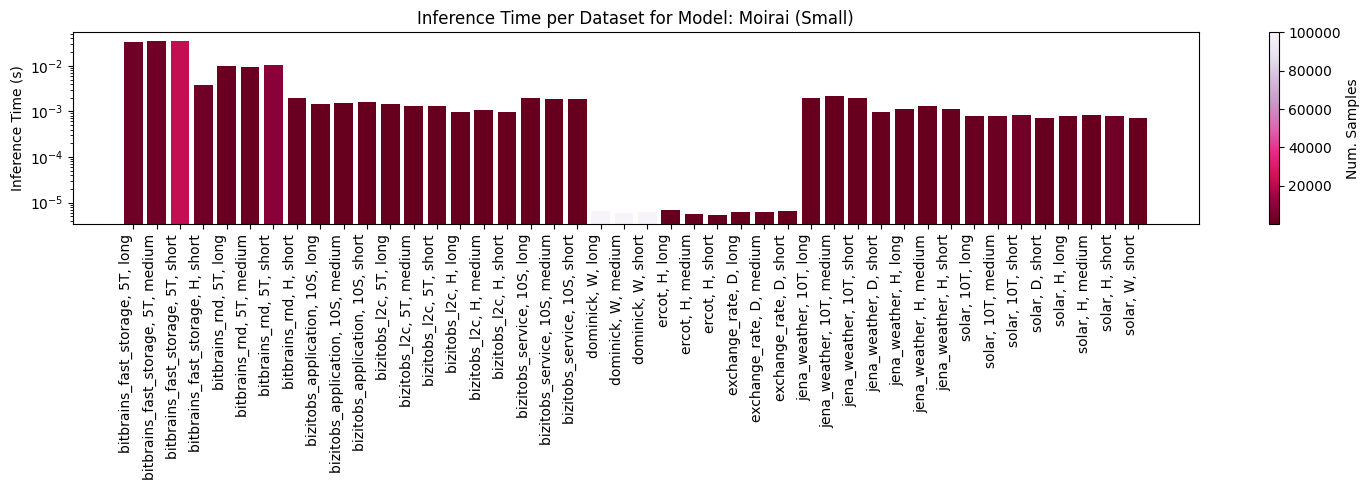

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


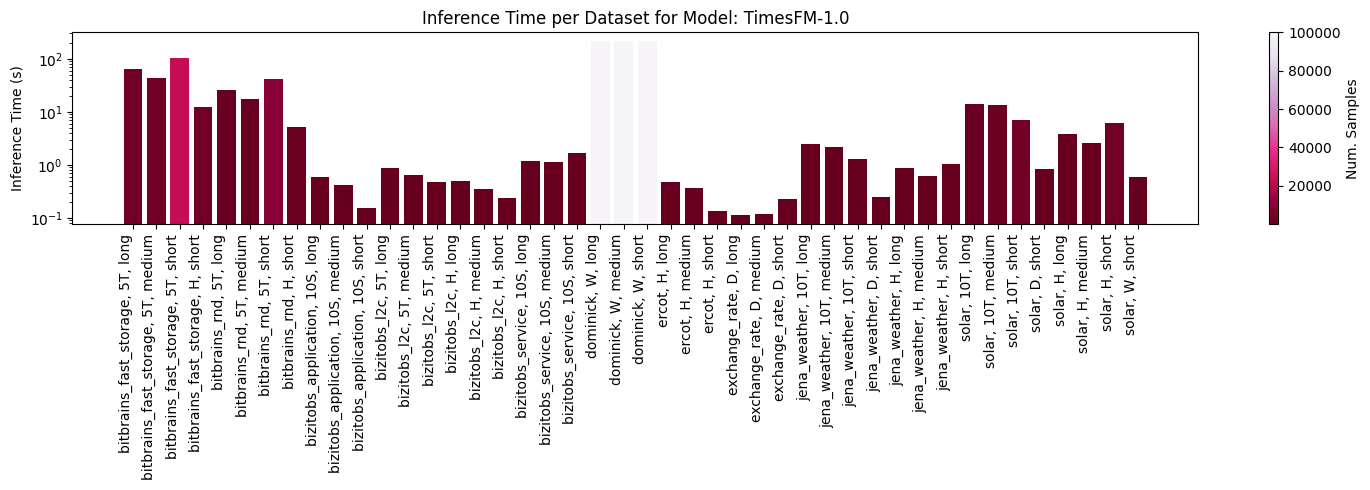

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3867187873.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


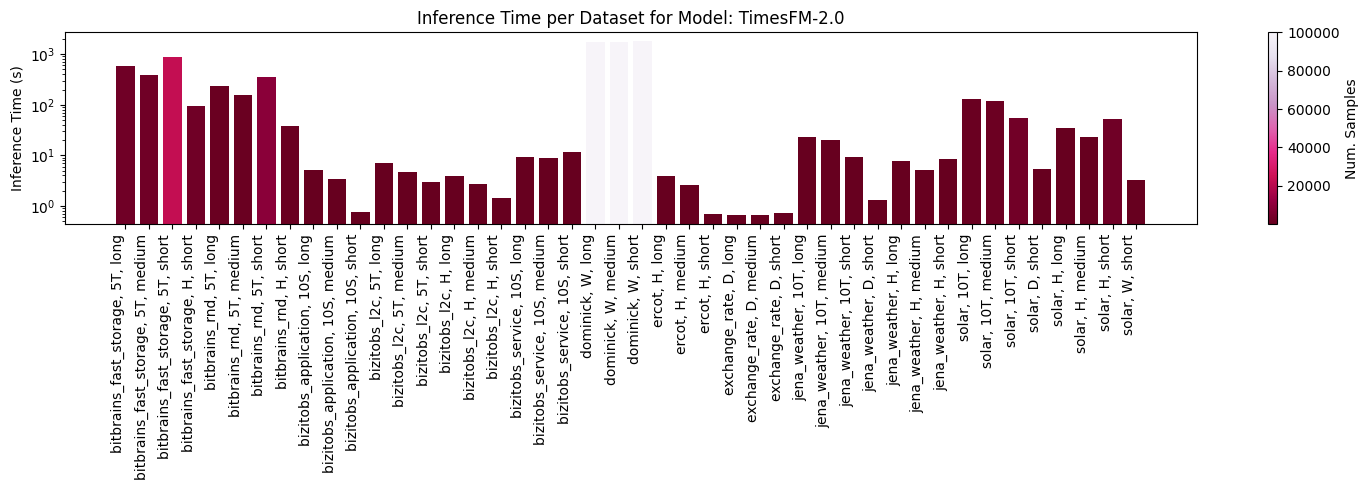

In [40]:
for model in models:
    sub_df = df[df['Model'] == model].copy()
    #sub_df.sort_values("inference_time", inplace=True)

    fig, ax = plt.subplots(figsize=(15, 5))

    """
    norm = plt.Normalize(sub_df["prediction_length"].min(), sub_df["prediction_length"].max())
    cmap = plt.cm.PuRd
    colors = cmap(norm(sub_df["prediction_length"]))
    """
    norm = plt.Normalize(sub_df["num_samples"].min(), sub_df["num_samples"].max())
    cmap = plt.cm.PuRd.reversed()
    colors = cmap(norm(sub_df["num_samples"]))

    bars = ax.bar(
        sub_df["dataset"],
        sub_df["inference_time"], # "normalized_time_per_input_output_point"
        color=colors
    )

    for bar, ns, ts_len in zip(bars, sub_df["num_samples"], sub_df["time_series_avg_len"]):
        height = bar.get_height()
        """
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"n={ns}\nlen={ts_len:.0f}",
            ha='center',
            va='bottom',
            fontsize=8
        )
        """

    ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')
    ax.set_ylabel("Inference Time (s)")
    ax.set_yscale("log")
    ax.set_title(f"Inference Time per Dataset for Model: {MODEL_NAME[model]}")

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label("Num. Samples") #"Prediction Length")

    plt.tight_layout()
    plt.show()

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


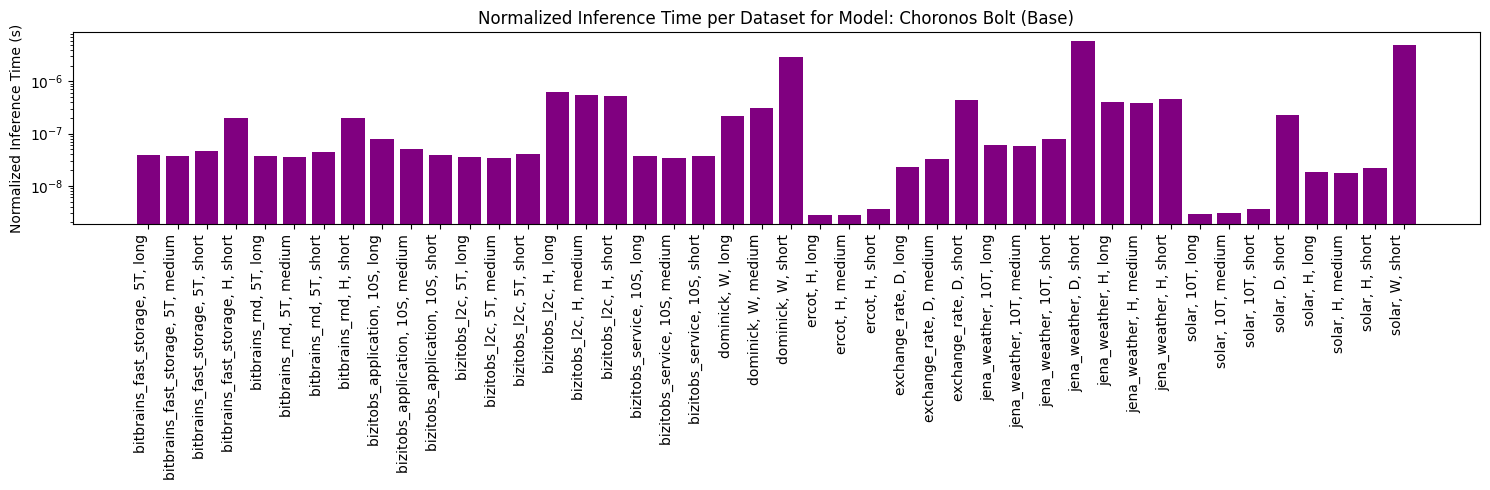

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


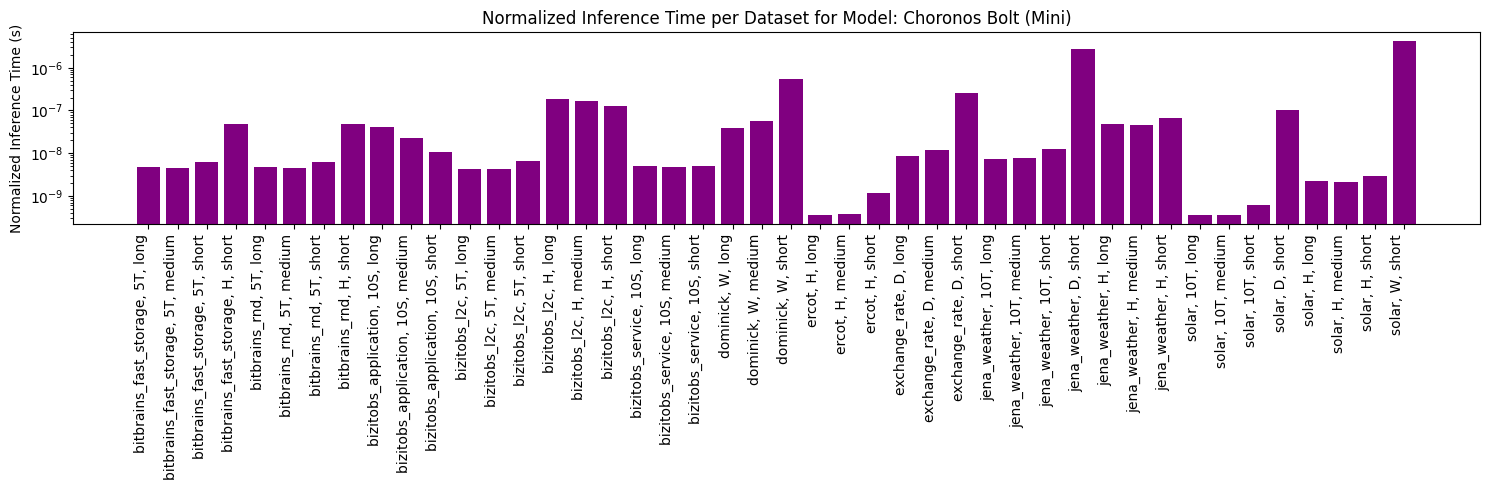

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


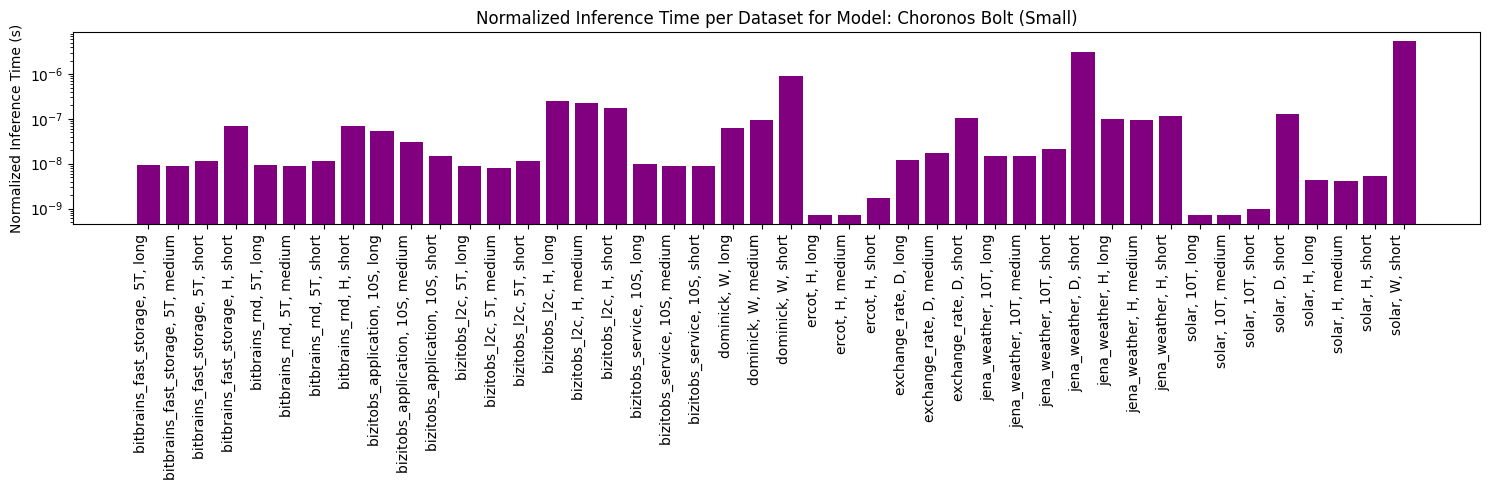

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


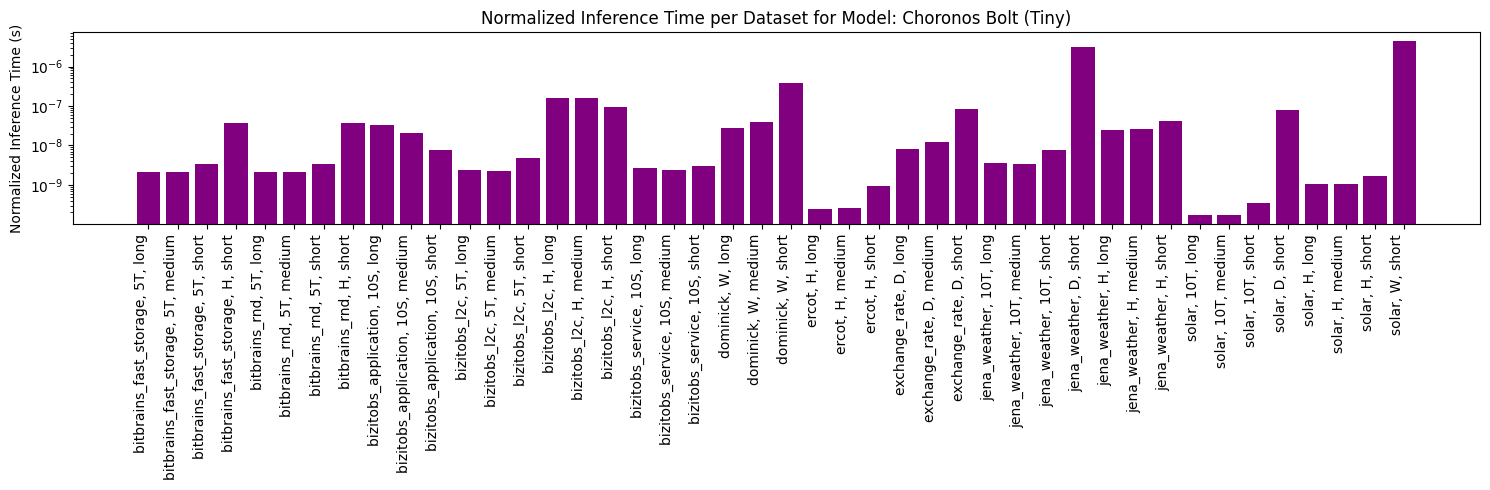

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


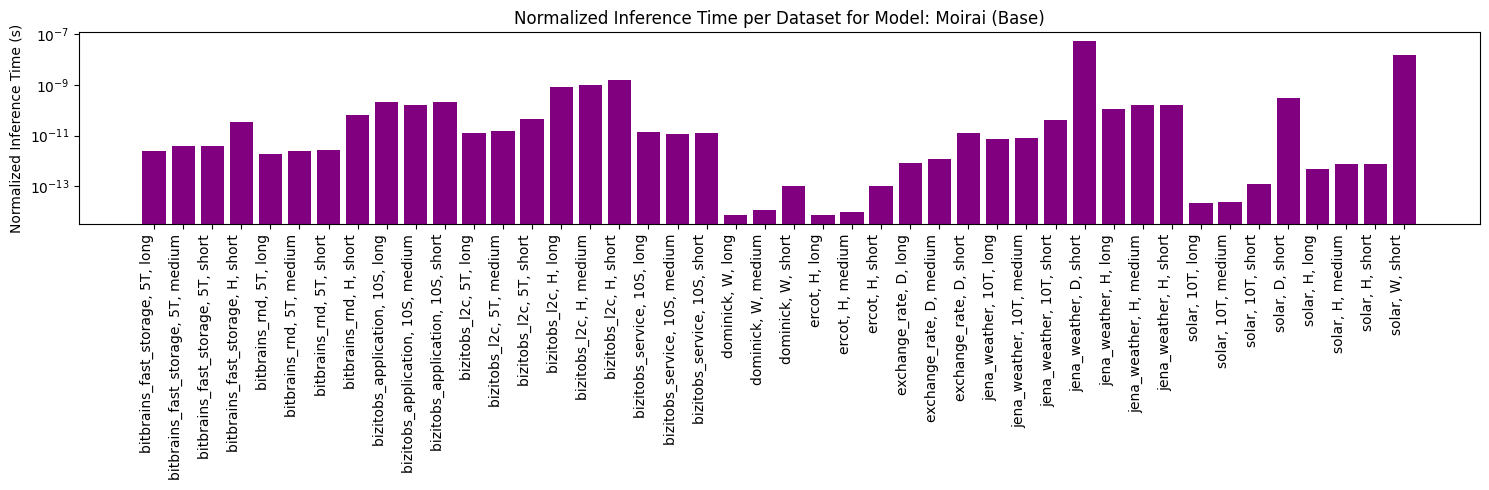

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


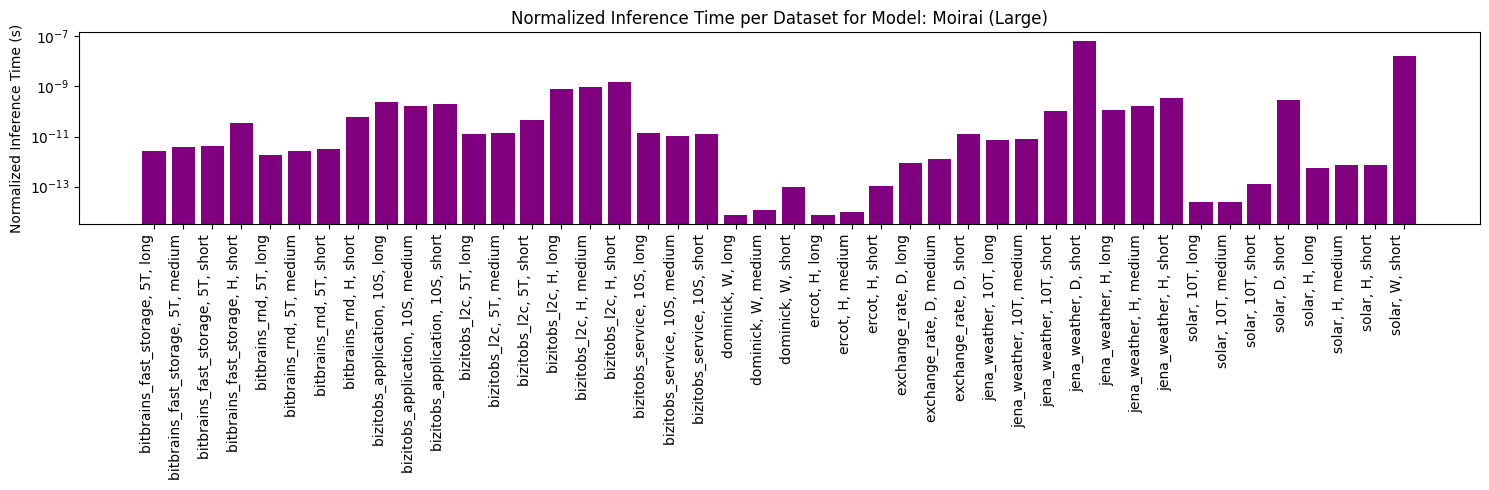

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


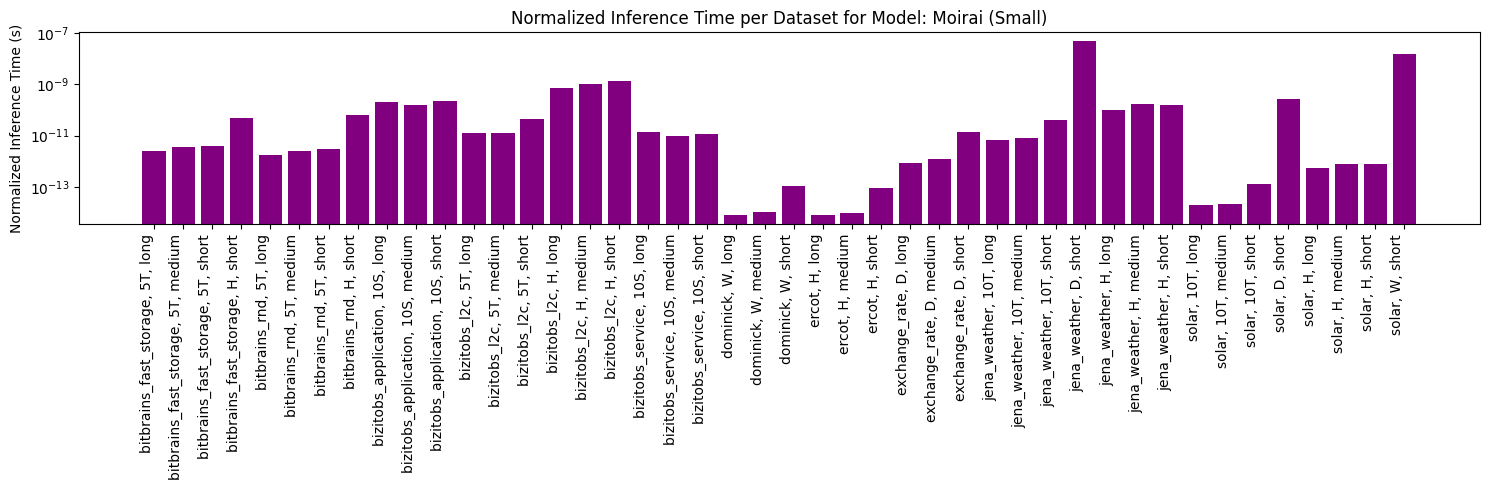

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


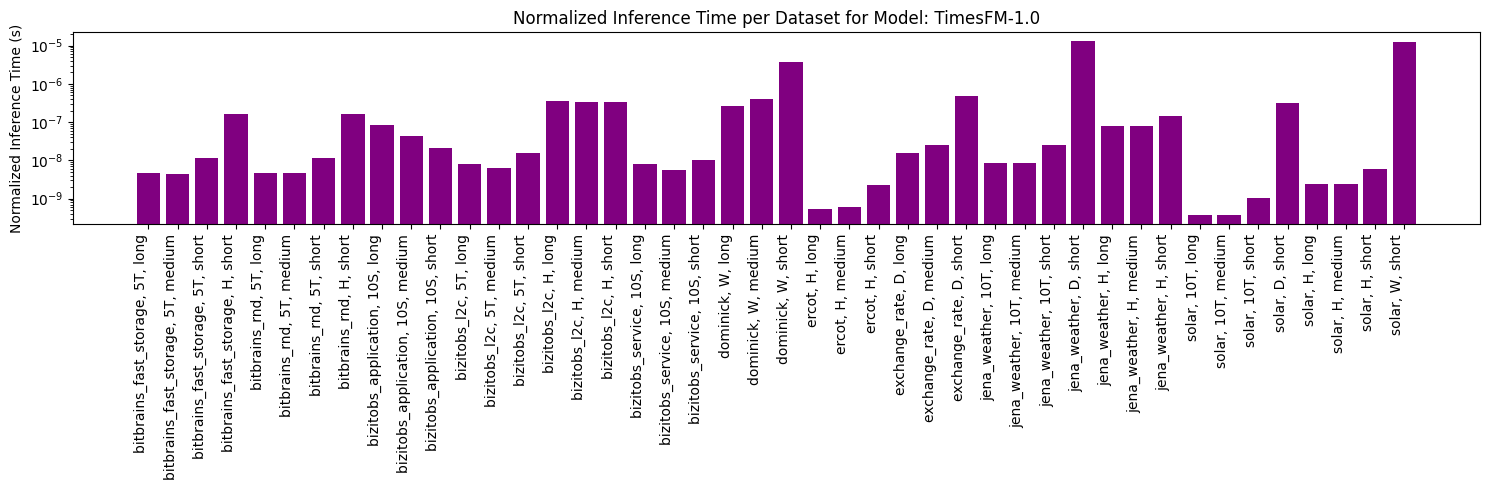

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\3531868355.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


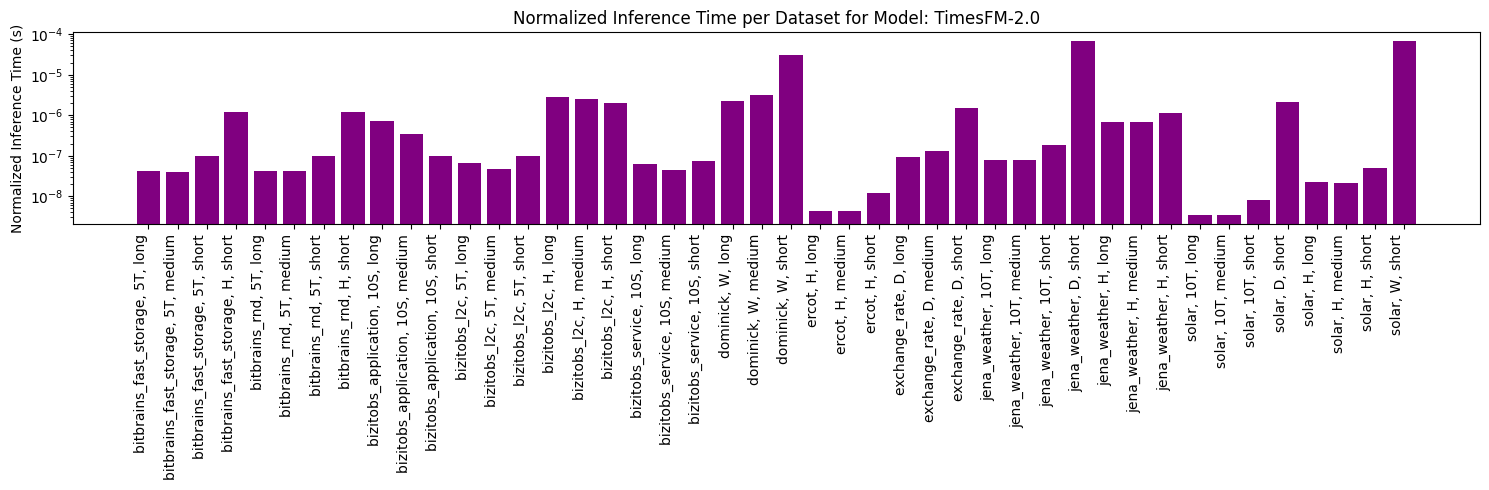

In [41]:
for model in models:
    sub_df = df[df['Model'] == model].copy()

    fig, ax = plt.subplots(figsize=(15, 5))
    bars = ax.bar(
        sub_df["dataset"],
        sub_df["normalized_time_per_input_output_point"],
        color="purple"
    )

    ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')
    ax.set_ylabel("Normalized Inference Time (s)")
    ax.set_yscale("log")
    ax.set_title(f"Normalized Inference Time per Dataset for Model: {MODEL_NAME[model]}")

    plt.tight_layout()
    plt.show()

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


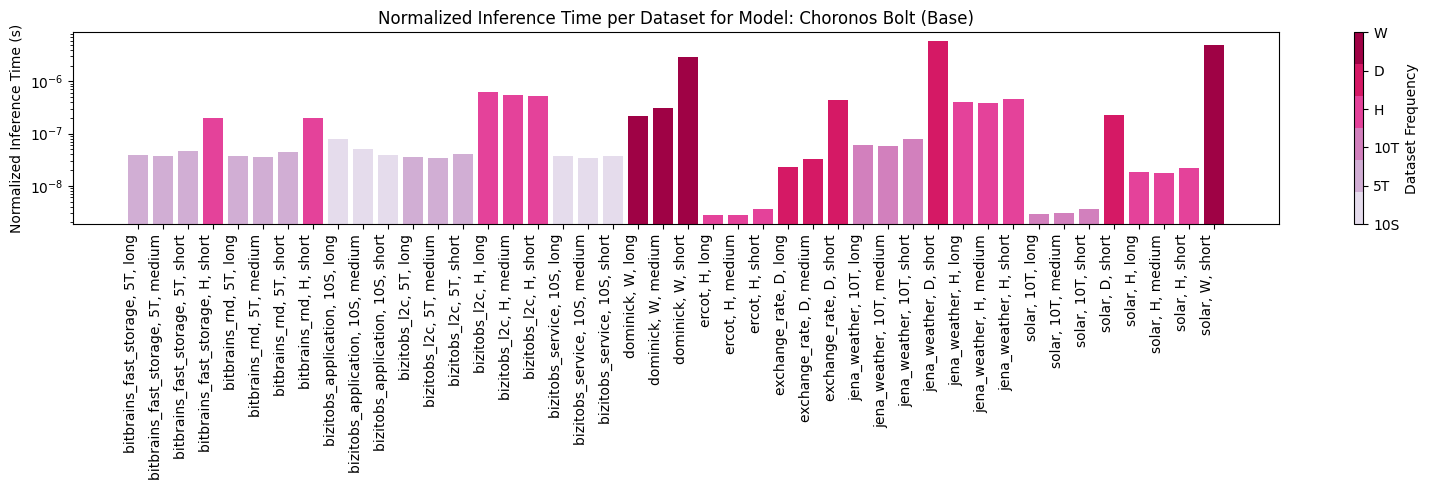

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


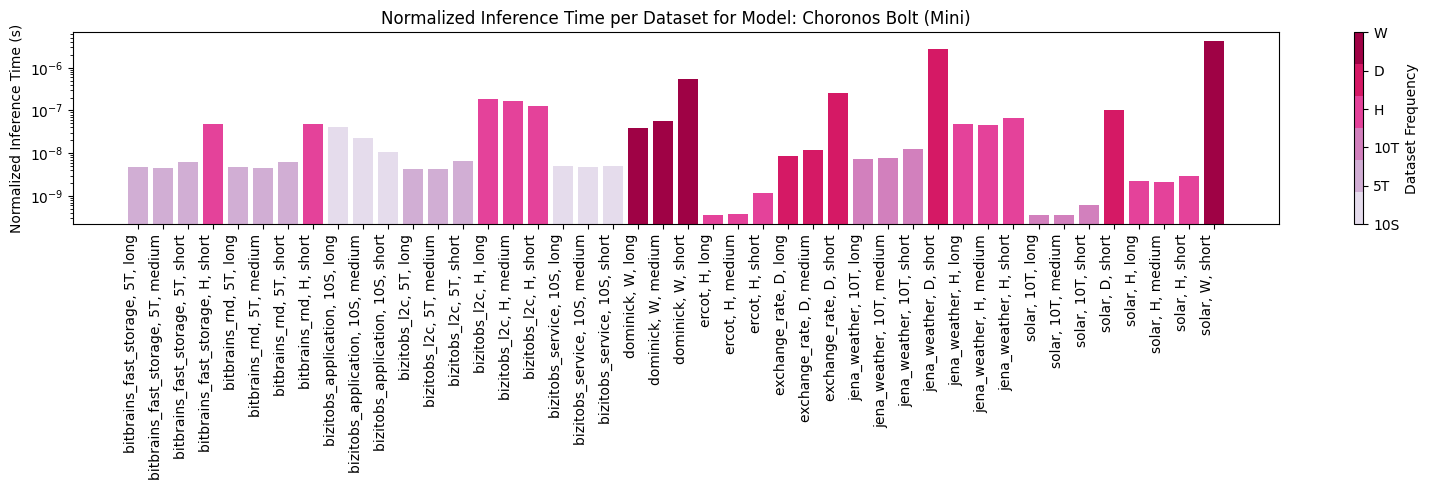

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


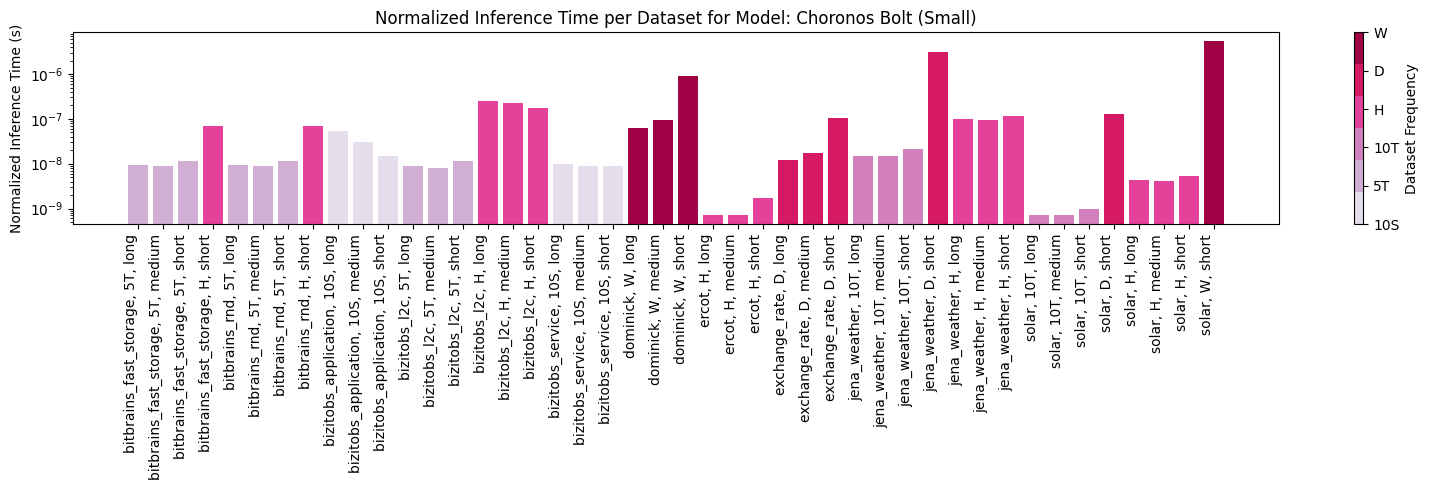

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


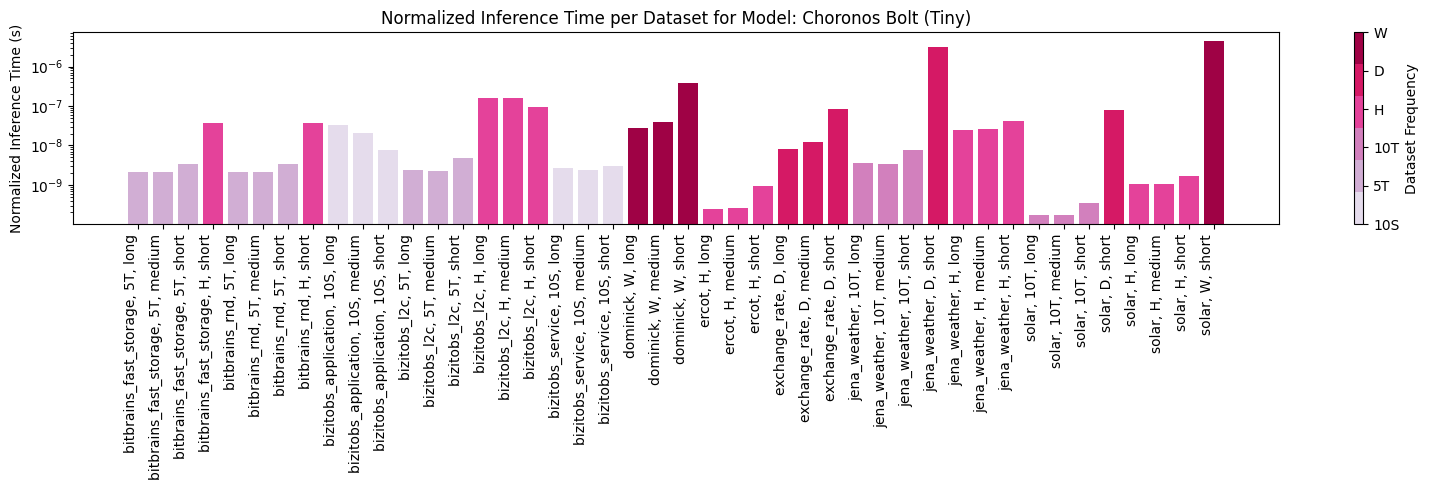

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


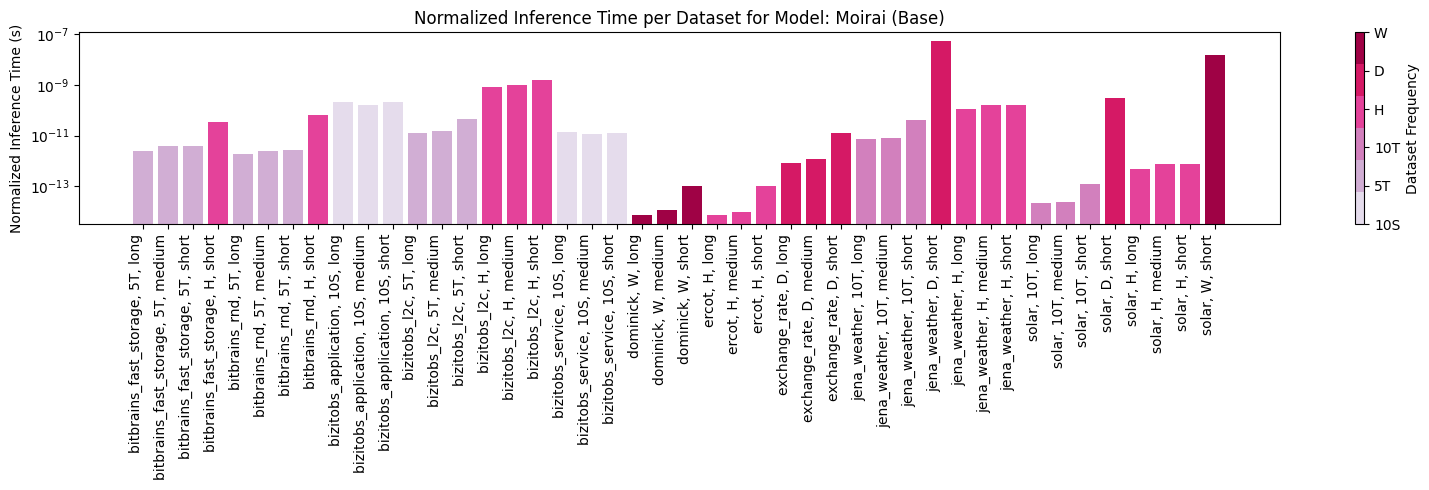

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


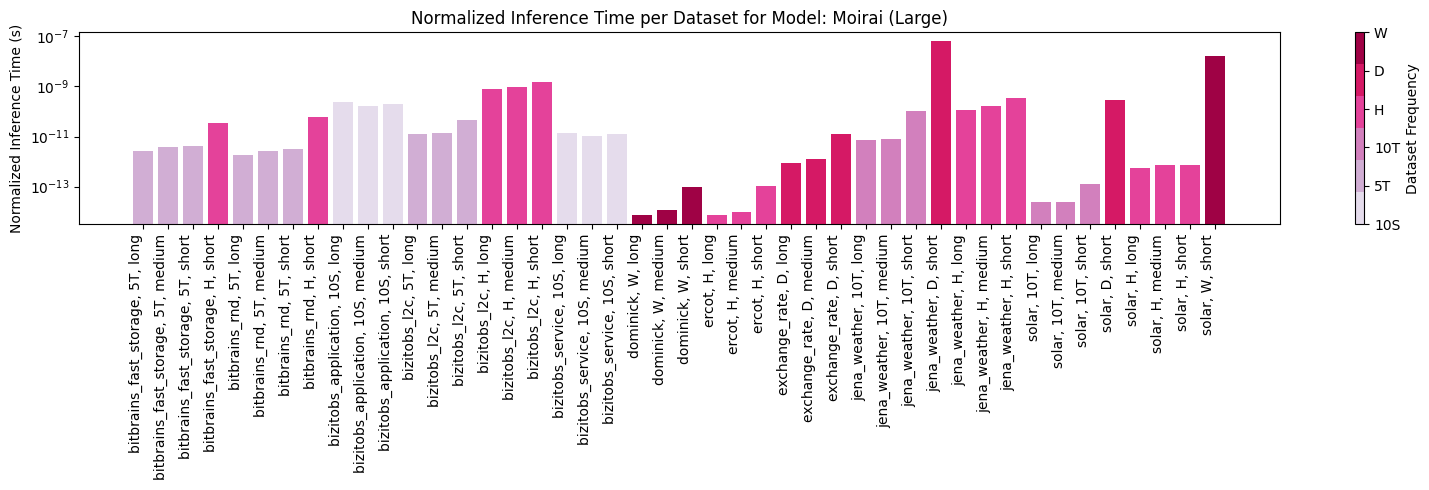

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


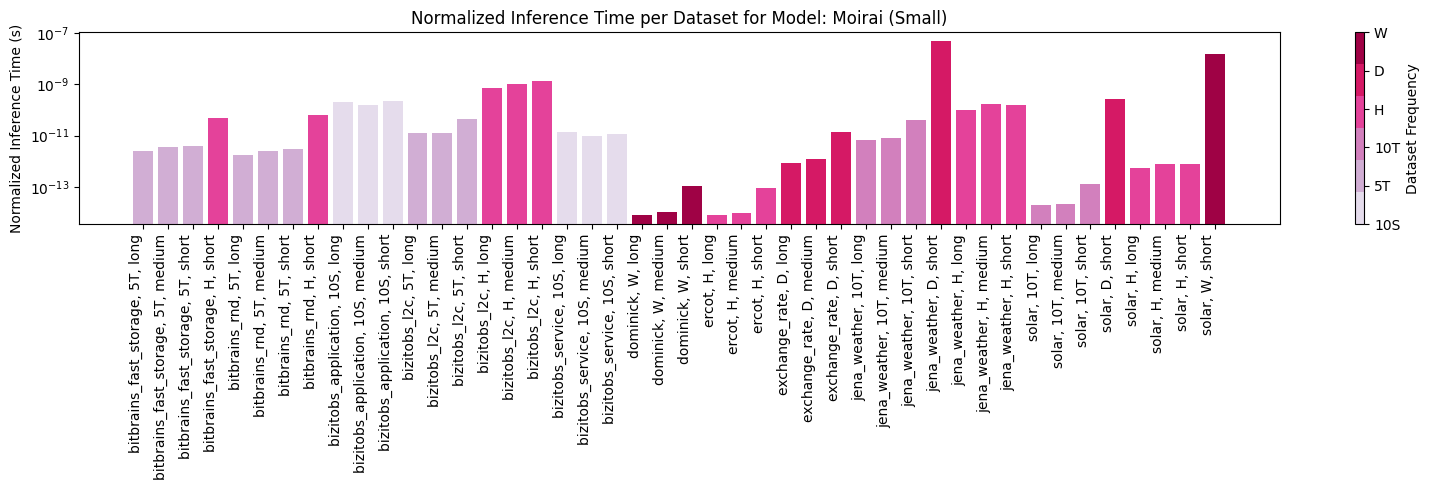

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


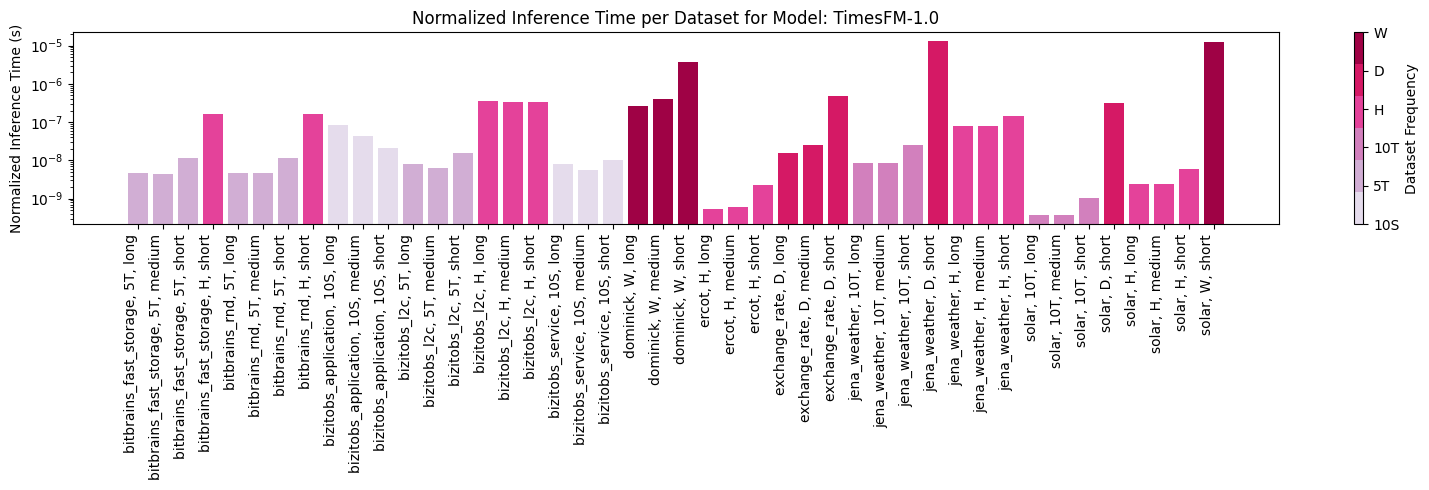

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\2153217618.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')


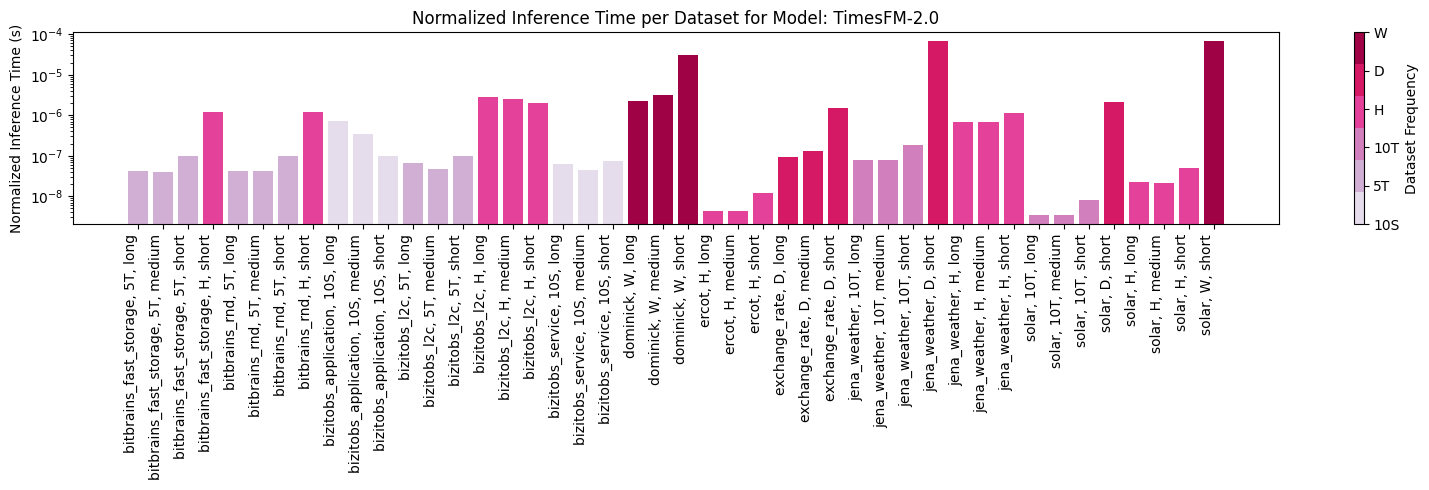

In [42]:
# Ordine personalizzato delle frequenze
freq_order = ['10S', '5T', '10T', 'H', 'D', 'W']

# Palette colori: un colore per ciascuna frequenza
palette = sns.color_palette("PuRd", len(freq_order))
cmap = ListedColormap(palette)

# Mappiamo ciascuna frequenza a un indice numerico per colormap
freq_to_idx = {f: i for i, f in enumerate(freq_order)}

models = df['Model'].unique()

for model in models:
    sub_df = df[df['Model'] == model].copy()
    sub_df = sub_df[sub_df['frequency'].isin(freq_order)]
    sub_df["freq_idx"] = sub_df["frequency"].map(freq_to_idx)

    fig, ax = plt.subplots(figsize=(16, 5))

    bars = ax.bar(
        sub_df["Dataset, Frequency, Term"],
        sub_df["normalized_time_per_input_output_point"],
        color=[cmap(i) for i in sub_df["freq_idx"]],
    )

    ax.set_xticklabels(sub_df["Dataset, Frequency, Term"], rotation=90, ha='right')
    ax.set_ylabel("Normalized Inference Time (s)")
    ax.set_yscale("log")
    ax.set_title(f"Normalized Inference Time per Dataset for Model: {MODEL_NAME[model]}")

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(freq_order)-1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, ticks=range(len(freq_order)))
    cbar.ax.set_yticklabels(freq_order)
    cbar.set_label("Dataset Frequency")

    plt.tight_layout()
    plt.show()

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


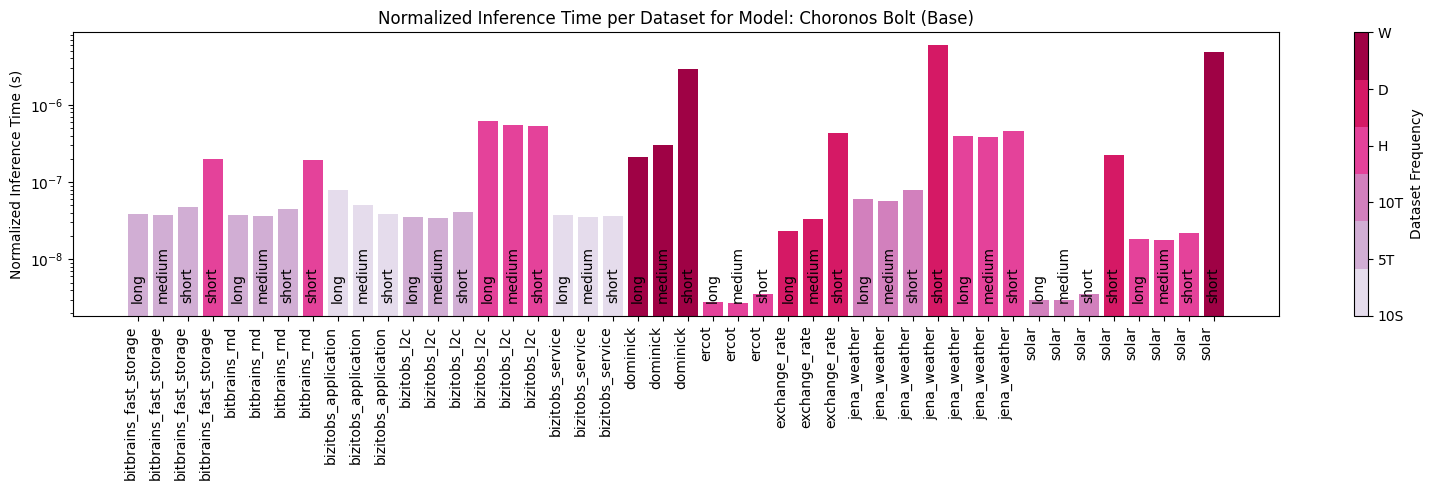

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


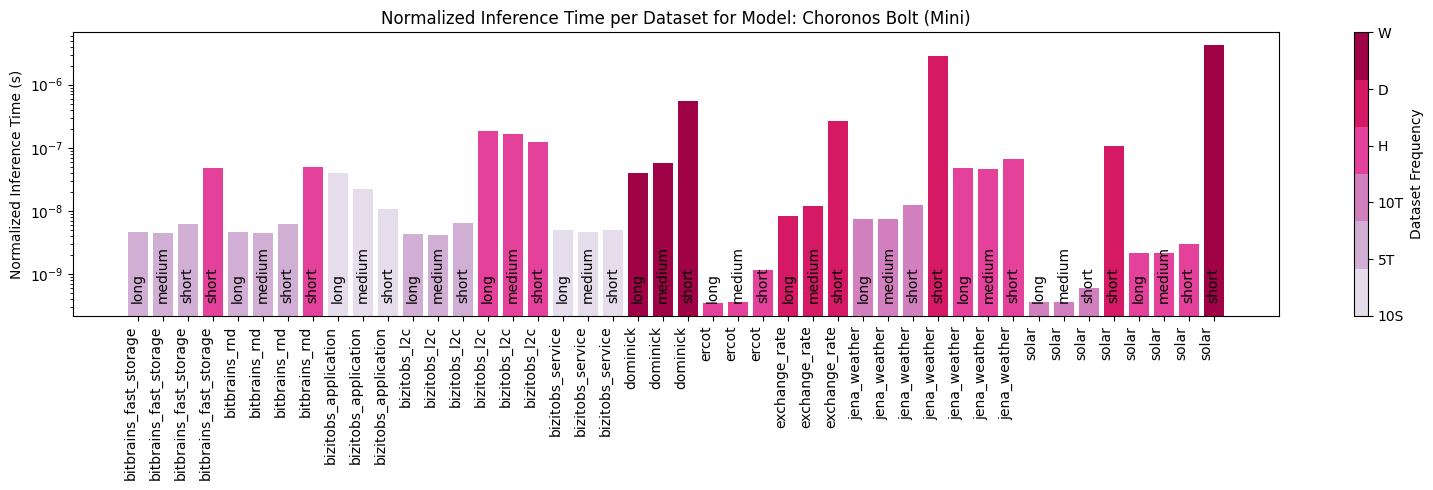

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


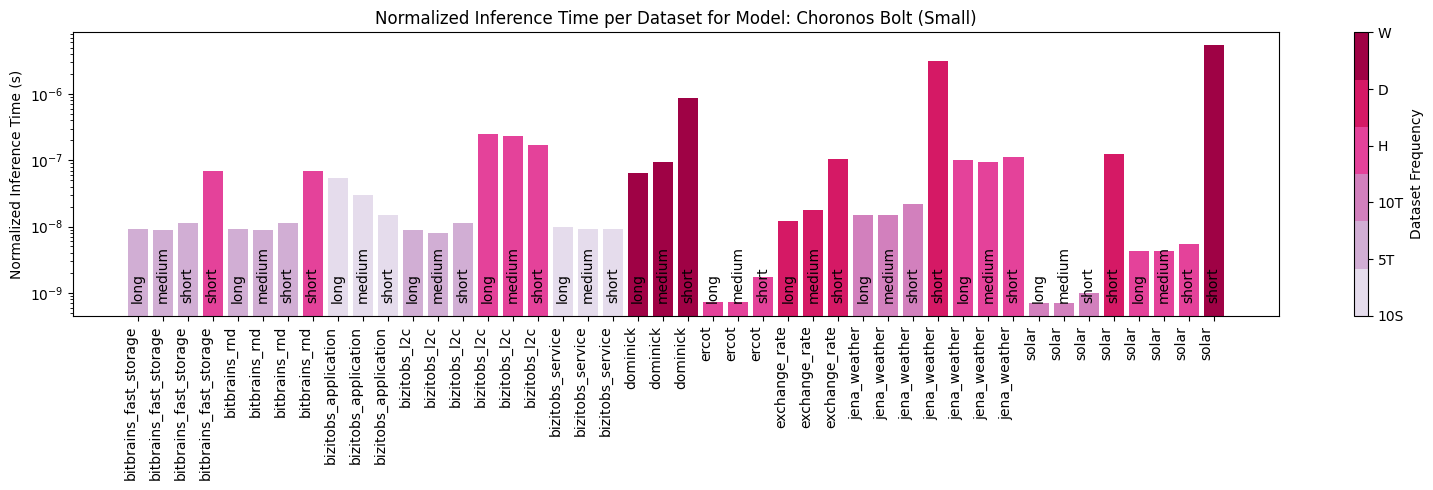

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


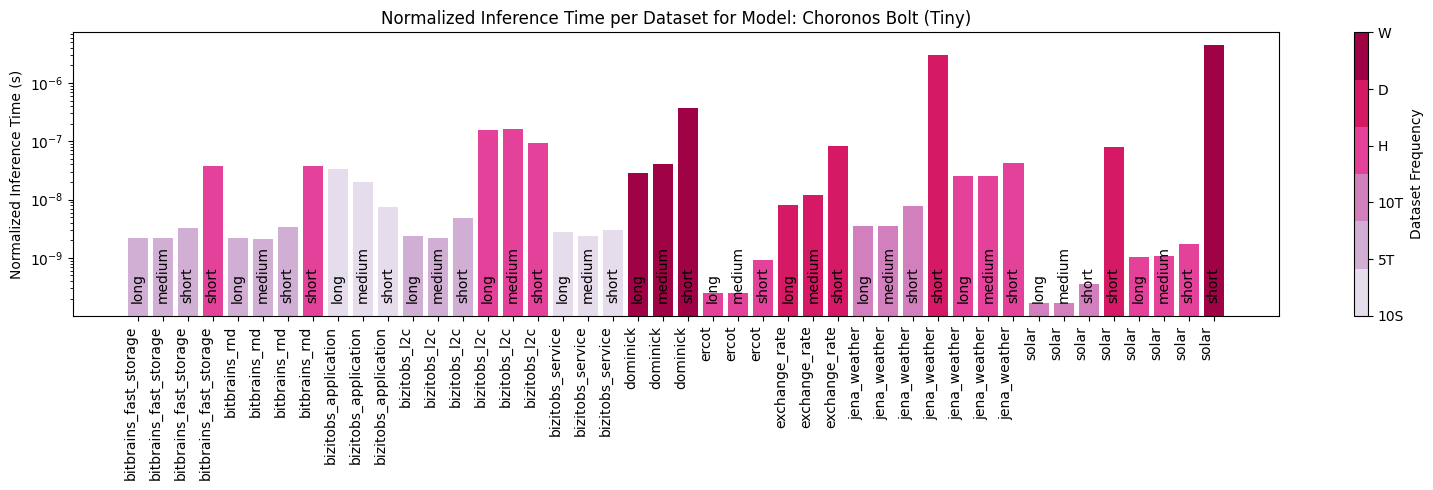

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


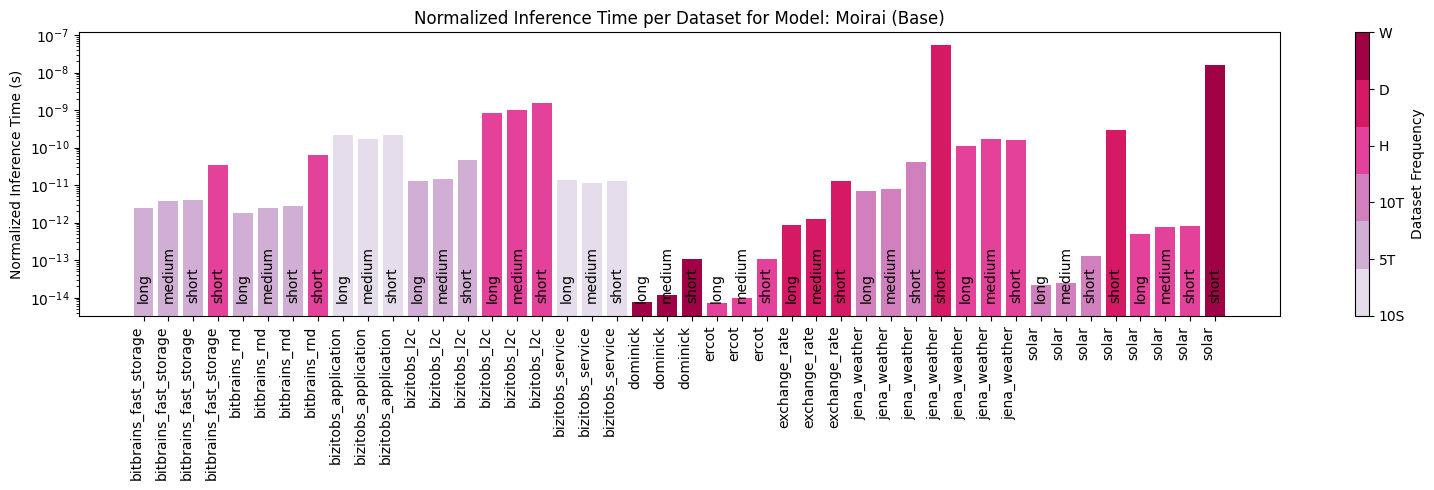

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


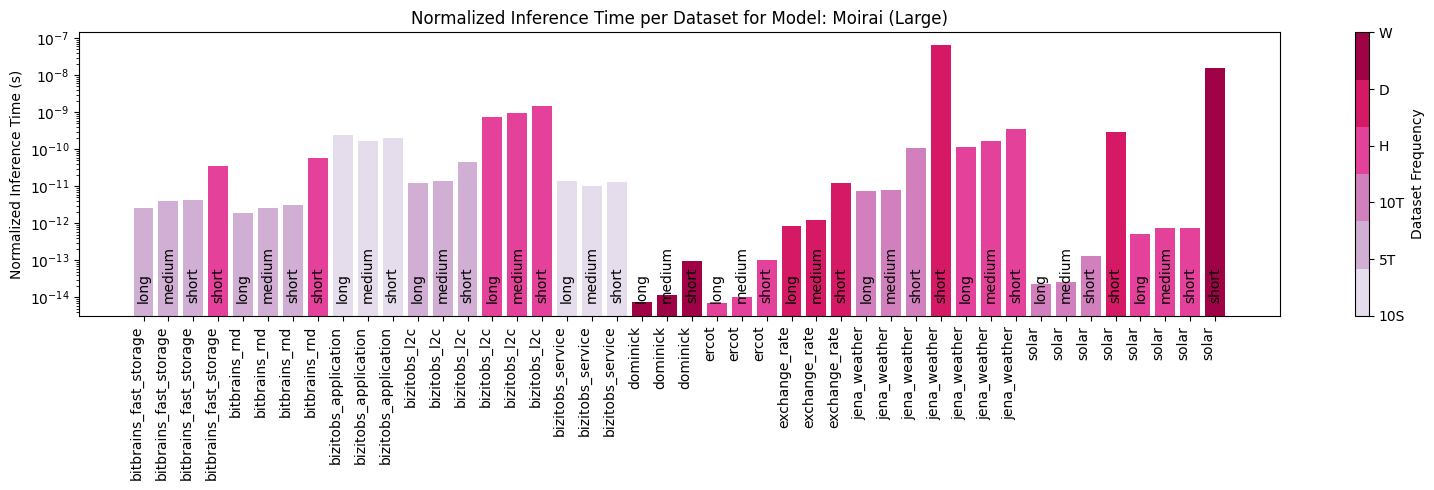

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


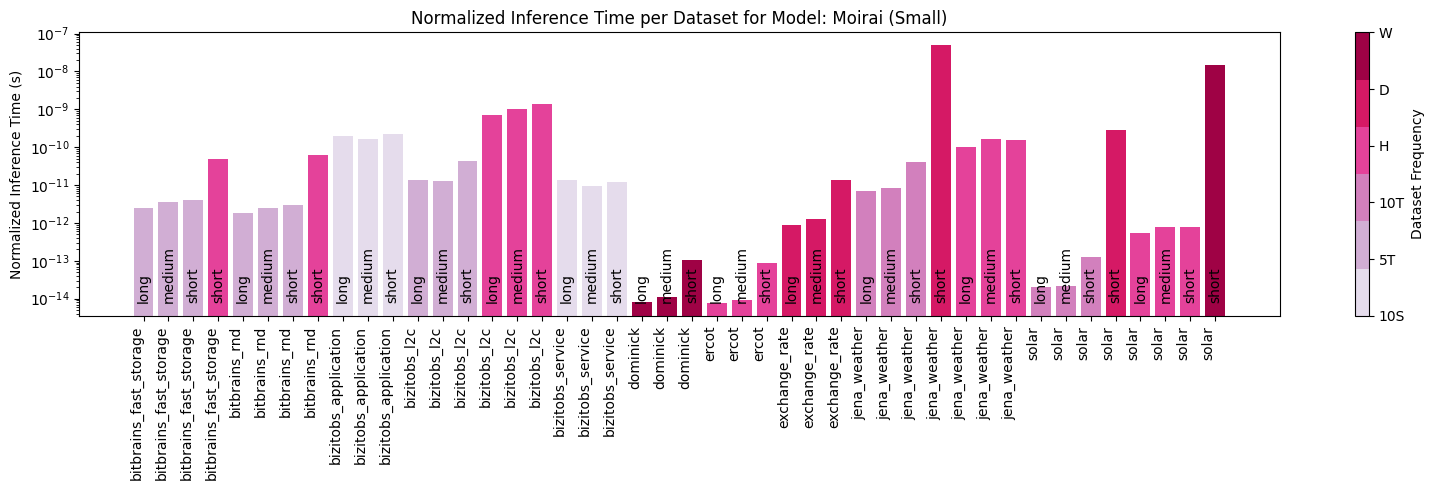

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


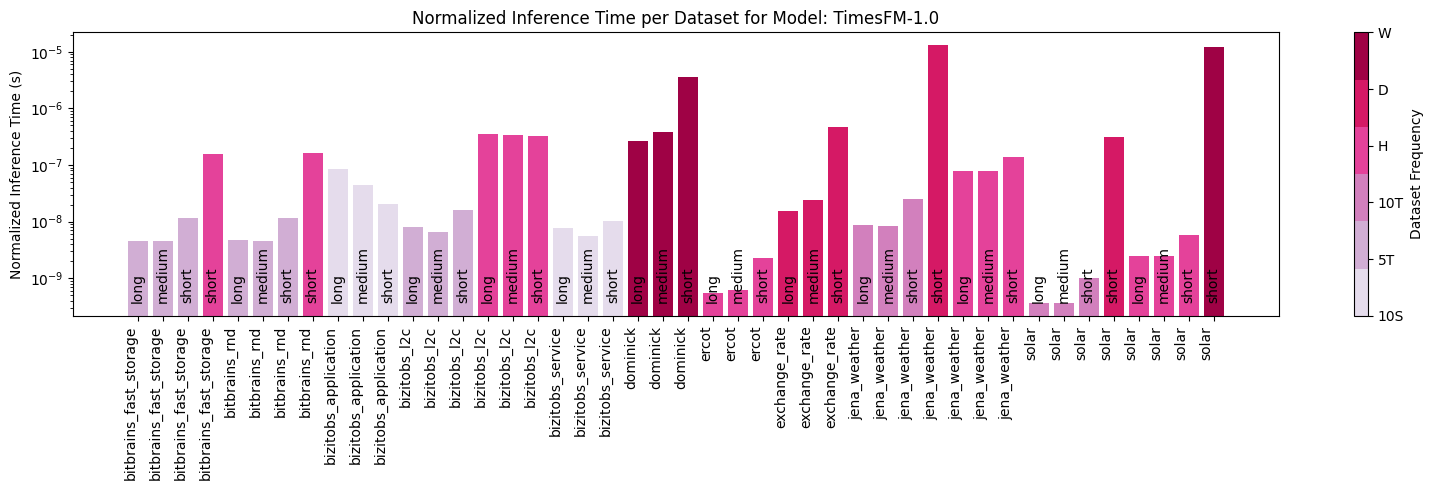

C:\Users\giuli\AppData\Local\Temp\ipykernel_27212\1409467700.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')


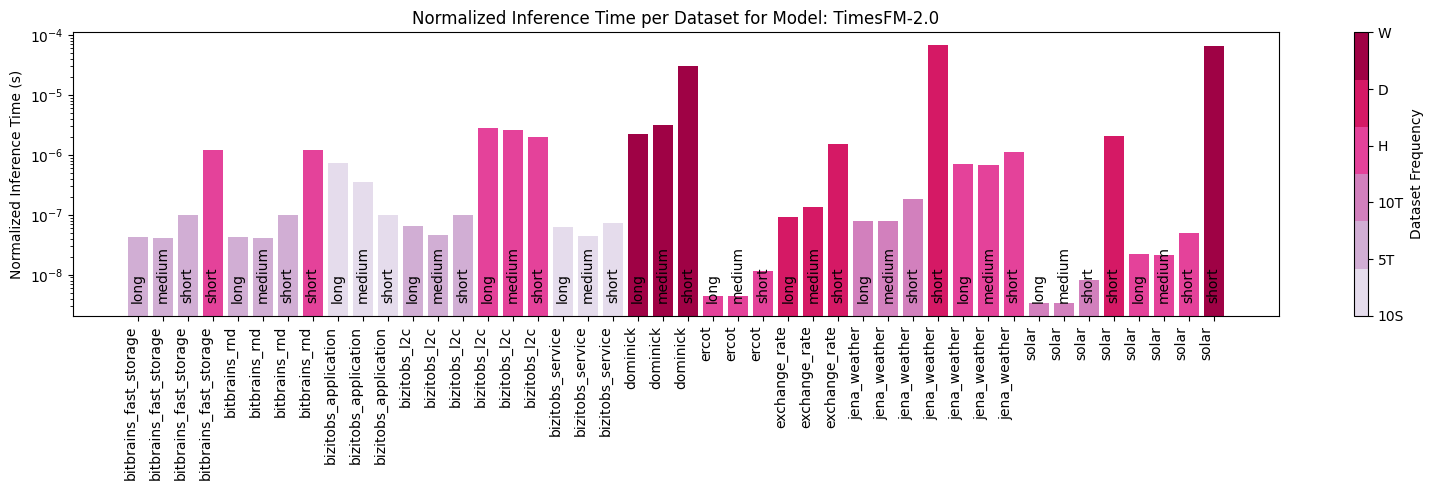

In [43]:
# Ordine frequenze e mappatura a colori
freq_order = ['10S', '5T', '10T', 'H', 'D', 'W']
palette = sns.color_palette("PuRd", len(freq_order))
cmap = ListedColormap(palette)
freq_to_idx = {f: i for i, f in enumerate(freq_order)}

# Aggiunta indice colore
df["freq_idx"] = df["frequency"].map(freq_to_idx)

models = df['Model'].unique()

for model in models:
    sub_df = df[df['Model'] == model].copy()
    sub_df = sub_df[sub_df['frequency'].isin(freq_order)]
    sub_df["freq_idx"] = sub_df["frequency"].map(freq_to_idx)

    fig, ax = plt.subplots(figsize=(16, 5))

    bars = ax.bar(
        sub_df["Dataset, Frequency, Term"],
        sub_df["normalized_time_per_input_output_point"],
        color=[cmap(i) for i in sub_df["freq_idx"]],
    )

    y = 1
    for bar in bars:
        y = min(y, bar.get_height())
    for i, bar in enumerate(bars):
        term = sub_df.iloc[i]['term']
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            y,
            term,
            ha='center',
            va='bottom',
            fontsize=10,
            rotation=90
        )

    ax.set_xticklabels(sub_df["dataset_name"], rotation=90, ha='right')
    ax.set_ylabel("Normalized Inference Time (s)")
    ax.set_yscale("log")
    ax.set_title(f"Normalized Inference Time per Dataset for Model: {MODEL_NAME[model]}")

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=len(freq_order)-1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, ticks=range(len(freq_order)))
    cbar.ax.set_yticklabels(freq_order)
    cbar.set_label("Dataset Frequency")

    plt.tight_layout()
    plt.show()

### Pareto Frontier

In [44]:
gift_eval_results_df = pd.read_csv("results/all_results.csv")
chronos_results_df = pd.read_csv("results/chronos_benchmark.csv")

In [45]:
gift_eval_results_df.head(2)

dataset, frequency, term Metric   Chr.B.B   Chr.B.S   Chr.B.M  \
0  bizitobs_application, 10S, short   MASE  5.533290  5.406632  7.201342   
1  bizitobs_application, 10S, short  Qloss  0.053958  0.034530  0.072335   

    Chr.B.T        T.FM1     T.FM2     Moi.S     Moi.B     Moi.L  Moi.M.S  \
0  7.547395  1391.842484  1.560993  4.151204  5.326189  4.035421      NaN   
1  0.069873    28.269510  0.014470  0.050196  0.029959  0.036407      NaN   

    Best  
0  T.FM2  
1  T.FM2

In [46]:
chronos_results_df.head(2)

dataset, term Metric   Chr.B.B   Chr.B.S   Chr.B.M   Chr.B.T  \
0  exchange_rate, short   MASE  1.249064  0.802832  1.105789  1.253411   
1  exchange_rate, short  Qloss  0.004579  0.003843  0.004379  0.004178   

      T.FM1     T.FM2     Moi.S     Moi.B     Moi.L     Best  
0  0.962424  1.254216  1.207863  0.844398  1.668695  Chr.B.S  
1  0.003686  0.003856  0.004574  0.003251  0.004371    Moi.B

In [47]:
gift_eval_results_df["dataset"] = gift_eval_results_df["dataset, frequency, term"].str.replace(", ", "/", regex=False)
chronos_results_df["dataset"] = chronos_results_df["dataset, term"].str.replace(", ", "/", regex=False)

In [48]:
results_df = pd.concat([
    gift_eval_results_df[['dataset', 'Metric', 'Chr.B.B', 'Chr.B.S', 'Chr.B.M', 'Chr.B.T',
    'T.FM1', 'T.FM2', 'Moi.S', 'Moi.B', 'Moi.L', 'Best']],
    chronos_results_df[['dataset', 'Metric', 'Chr.B.B', 'Chr.B.S', 'Chr.B.M', 'Chr.B.T',
    'T.FM1', 'T.FM2', 'Moi.S', 'Moi.B', 'Moi.L', 'Best']]
    ])

In [49]:
results_df.head(3)

dataset Metric   Chr.B.B   Chr.B.S   Chr.B.M  \
0  bizitobs_application/10S/short   MASE  5.533290  5.406632  7.201342   
1  bizitobs_application/10S/short  Qloss  0.053958  0.034530  0.072335   
2  bizitobs_application/10S/short   Rank  6.000000  4.000000  7.500000   

    Chr.B.T        T.FM1     T.FM2     Moi.S     Moi.B     Moi.L   Best  
0  7.547395  1391.842484  1.560993  4.151204  5.326189  4.035421  T.FM2  
1  0.069873    28.269510  0.014470  0.050196  0.029959  0.036407  T.FM2  
2  7.500000     9.000000  1.000000  4.000000  3.000000  3.000000  T.FM2

In [50]:
def create_dataset_df(df, dataset_name):
    dataset_df = df[df["dataset"] == dataset_name]
    dataset_df = dataset_df.drop(columns=['dataset'])
    #dataset_df = dataset_df.rename(columns={"model": "dataset"})
    dataset_df = dataset_df.set_index("model")
    dataset_df = dataset_df.transpose()
    dataset_df = dataset_df.rename(columns={"chronos_bolt_base": "Chr.B.B",
                                            "chronos_bolt_small": "Chr.B.S",
                                            "chronos_bolt_mini": "Chr.B.M",
                                            "chronos-bolt-mini": "Chr.B.M",
                                            "chronos_bolt_tiny": "Chr.B.T",
                                            "timesfm1": "T.FM1",
                                            "timesfm2": "T.FM2",
                                            "moirai_small": "Moi.S",
                                            "moirai_base": "Moi.B",
                                            "moirai_large": "Moi.L",
                                            })
    dataset_df["Best"] = dataset_df.idxmin(axis=1) # add columns best
    dataset_df["dataset"] = dataset_name
    return dataset_df[['dataset', 'Chr.B.B', 'Chr.B.M', 'Chr.B.S', 'Chr.B.T', 'Moi.B', 'Moi.L', 'Moi.S',
        'T.FM1', 'T.FM2', 'Best']]

create_dataset_df(df[['model', 'dataset','inference_time']], "bizitobs_application/10S/short")

model                                  dataset   Chr.B.B   Chr.B.M   Chr.B.S  \
inference_time  bizitobs_application/10S/short  0.291949  0.079531  0.112463   

model            Chr.B.T     Moi.B     Moi.L     Moi.S     T.FM1     T.FM2  \
inference_time  0.056077  0.001608  0.001534  0.001634  0.155581  0.760617   

model            Best  
inference_time  Moi.L

In [51]:
dataset_names = df["dataset"].unique()

In [52]:
final_df = pd.DataFrame()

for name in dataset_names:
    dataset_df = create_dataset_df(df[['model', 'dataset','inference_time']], name)
    final_df = pd.concat([final_df, dataset_df], ignore_index=True)

In [53]:
final_df

model                           dataset     Chr.B.B    Chr.B.M     Chr.B.S  \
0        bitbrains_fast_storage/5T/long  526.805580  63.621771  124.187846   
1      bitbrains_fast_storage/5T/medium  352.916874  43.141423   84.064037   
2       bitbrains_fast_storage/5T/short  418.579793  55.380746  100.698756   
3        bitbrains_fast_storage/H/short   15.443538   3.794846    5.338827   
4                 bitbrains_rnd/5T/long  205.008266  25.212700   49.874878   
5               bitbrains_rnd/5T/medium  137.776266  17.137803   33.590901   
6                bitbrains_rnd/5T/short  157.116363  22.303288   40.458061   
7                 bitbrains_rnd/H/short    6.076143   1.523404    2.165761   
8         bizitobs_application/10S/long    0.556571   0.288937    0.386832   
9       bizitobs_application/10S/medium    0.484171   0.214706    0.285486   
10       bizitobs_application/10S/short    0.291949   0.079531    0.112463   
11                 bizitobs_l2c/5T/long    3.798916   0.468074    0.950394   
12               bizitobs_l2c/5T/medium    3.476972   0.422331    0.801035   
13                bizitobs_l2c/5T/short    1.253232   0.195805    0.338691   
14                  bizitobs_l2c/H/long    0.869662   0.256702    0.342692   
15                bizitobs_l2c/H/medium    0.576756   0.174072    0.241082   
16                 bizitobs_l2c/H/short    0.379953   0.090376    0.122595   
17            bizitobs_service/10S/long    5.580441   0.741051    1.495831   
18          bizitobs_service/10S/medium    6.968801   0.936318    1.816583   
19           bizitobs_service/10S/short    5.777774   0.800323    1.435516   
20                        dominick/long  170.389430  31.880493   51.122744   
21                      dominick/medium  168.298312  31.767147   51.245762   
22                       dominick/short  173.686596  32.052784   52.117022   
23                           ercot/long    2.499639   0.309609    0.639107   
24                         ercot/medium    1.613838   0.218020    0.431309   
25                          ercot/short    0.212992   0.067959    0.101325   
26                   exchange_rate/long    0.165312   0.060602    0.085600   
27                 exchange_rate/medium    0.159050   0.058336    0.085017   
28                  exchange_rate/short    0.211230   0.127562    0.050961   
29                jena_weather/10T/long   17.094976   2.111756    4.186263   
30              jena_weather/10T/medium   14.928117   1.978594    3.971311   
31               jena_weather/10T/short    3.916938   0.615887    1.082508   
32                 jena_weather/D/short    0.113683   0.053852    0.060401   
33                  jena_weather/H/long    4.432617   0.525321    1.121363   
34                jena_weather/H/medium    2.975106   0.358899    0.737634   
35                 jena_weather/H/short    3.457533   0.498872    0.856668   
36                       solar/10T/long  115.340536  14.091690   27.423303   
37                     solar/10T/medium  107.871916  12.987898   25.201900   
38                      solar/10T/short   24.411923   4.116033    6.849891   
39                        solar/D/short    0.596044   0.276432    0.332259   
40                         solar/H/long   27.847902   3.300947    6.515448   
41                       solar/H/medium   18.635123   2.276375    4.443317   
42                        solar/H/short   22.559067   3.089613    5.546657   
43                        solar/W/short    0.234634   0.203142    0.262461   

model    Chr.B.T     Moi.B     Moi.L     Moi.S       T.FM1        T.FM2   Best  
0      29.391576  0.034362  0.036483  0.033504   62.838536   575.527537  Moi.S  
1      20.483352  0.035765  0.037799  0.034115   42.858526   382.361930  Moi.S  
2      29.083142  0.034708  0.038376  0.034859  103.654161   864.425776  Moi.B  
3       2.885971  0.002741  0.002734  0.003777   12.322267    92.706562  Moi.L  
4      11.709211  0.009906  0.010099  0.009757   25.283995   232.783936  Moi.S  
5  

In [54]:
mase_df = results_df[results_df["Metric"] == "MASE"].drop(columns=["Metric", "Best"])
qloss_df = results_df[results_df["Metric"] == "Qloss"].drop(columns=["Metric", "Best"])

merged_df = pd.merge(mase_df, qloss_df, on="dataset", suffixes=("_mase", "_qloss"))
merged_df = pd.merge(merged_df, final_df, on="dataset")

model_cols = ['Chr.B.B', 'Chr.B.S', 'Chr.B.M', 'Chr.B.T', 'T.FM1', 'T.FM2', 'Moi.S', 'Moi.B', 'Moi.L']

# MASE
mase_long = merged_df[["dataset"] + [col + "_mase" for col in model_cols]]
mase_long.columns = ["dataset"] + model_cols
mase_long = mase_long.melt(id_vars="dataset", var_name="model", value_name="MASE")

# Qloss
qloss_long = merged_df[["dataset"] + [col + "_qloss" for col in model_cols]]
qloss_long.columns = ["dataset"] + model_cols
qloss_long = qloss_long.melt(id_vars="dataset", var_name="model", value_name="Qloss")

# time
time_long = merged_df[["dataset"] + [col for col in model_cols]]
time_long.columns = ["dataset"] + model_cols
time_long = time_long.melt(id_vars="dataset", var_name="model", value_name="time")

# Merge
plot_df = pd.merge(mase_long, qloss_long, on=["dataset", "model"])
plot_df = pd.merge(plot_df, time_long, on=["dataset", "model"])

In [55]:
plot_df

dataset    model       MASE     Qloss      time
0     bizitobs_application/10S/short  Chr.B.B   5.533290  0.053958  0.291949
1    bizitobs_application/10S/medium  Chr.B.B   9.720338  0.103502  0.484171
2      bizitobs_application/10S/long  Chr.B.B  10.483795  0.108976  0.556571
3              bizitobs_l2c/5T/short  Chr.B.B   0.278185  0.074353  1.253232
4             bizitobs_l2c/5T/medium  Chr.B.B   0.877710  0.445441  3.476972
..                               ...      ...        ...       ...       ...
391                     ercot/medium    Moi.L   1.353243  0.062666  0.000006
392                       ercot/long    Moi.L   1.418154  0.064092  0.000006
393                   dominick/short    Moi.L   0.674720  0.300218  0.000006
394                  dominick/medium    Moi.L   1.007873  0.379057  0.000006
395                    dominick/long    Moi.L   1.195160  0.446397  0.000006

[396 rows x 5 columns]

### Plot

In [56]:
# Colori personalizzati (puoi usare nomi, codici HEX, ecc.)
custom_colors = {
    'Chr.B.B': "#0C092A",
    'Chr.B.S': "#1C0B9D",
    'Chr.B.M': "#3c00ff",
    'Chr.B.T': "#00cbfe",
    'T.FM1':   "#11ff00",
    'T.FM2':   "#0f8606",
    'Moi.S':   "#aa0f67",
    'Moi.B':   "#fe00ae",
    'Moi.L':   "#ff80d7"
}

# Marker personalizzati (puoi scegliere tra: 'o', 's', 'D', '^', 'v', '<', '>', 'P', 'X', '*')
custom_markers = {
    'Chr.B.B': 'o',
    'Chr.B.S': 'o',
    'Chr.B.M': 'o',
    'Chr.B.T': 'o',
    'T.FM1':   'v',
    'T.FM2':   'v',
    'Moi.S':   'X',
    'Moi.B':   'X',
    'Moi.L':   'X'
}


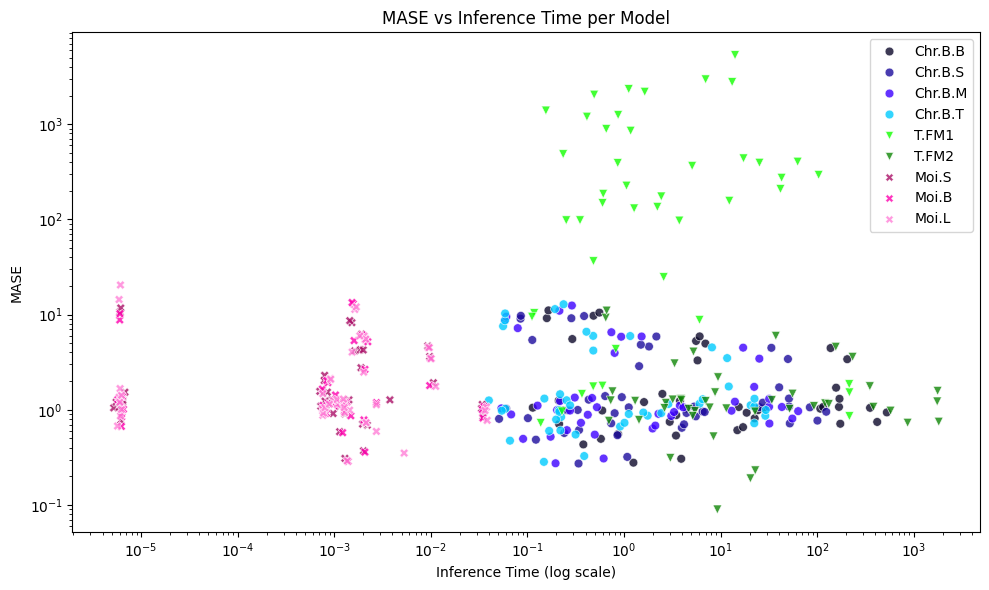

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

metric = "MASE"
sns.scatterplot(
    data=plot_df,
    x="time", y=metric,
    hue="model",
    style="model",
    palette=custom_colors,
    markers=custom_markers,
    s=40, alpha=0.8
)


# Aggiungi etichette dei dataset
for _, row in plot_df.iterrows():
    pass
    #plt.text(row["time"], row["metric"], row["dataset"], fontsize=4, alpha=0.6)

# Scala log-log
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Inference Time (log scale)")
plt.ylabel(f"{metric}")
plt.title(f"{metric} vs Inference Time per Model")

plt.legend()
#plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig(f"figures/MASE_vs_inference_time.pdf")
plt.show()

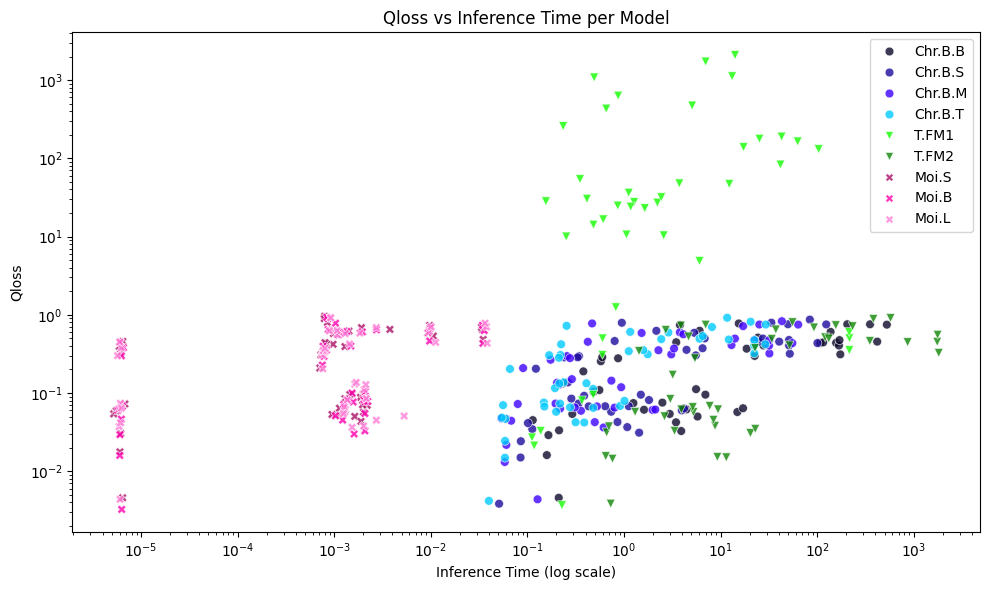

In [69]:
plt.figure(figsize=(10, 6))

metric = "Qloss"
sns.scatterplot(
    data=plot_df,
    x="time", y=metric,
    hue="model",
    style="model",
    palette=custom_colors,
    markers=custom_markers,
    s=40, alpha=0.8
)


# Aggiungi etichette dei dataset
for _, row in plot_df.iterrows():
    pass
    #plt.text(row["time"], row["metric"], row["dataset"], fontsize=4, alpha=0.6)

# Scala log-log
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Inference Time (log scale)")
plt.ylabel(f"{metric}")
plt.title(f"{metric} vs Inference Time per Model")

plt.legend()
#plt.grid(True, which="both", ls="--", alpha=0.3)
plt.tight_layout()
plt.savefig(f"figures/Qloss_vs_inference_time.pdf")
plt.show()

In [58]:
import matplotlib.pyplot as plt

model_list = ['Chr.B.B', 'Chr.B.S', 'Chr.B.M', 'Chr.B.T', 'T.FM1', 'T.FM2', 'Moi.S', 'Moi.B', 'Moi.L']
"""
for i, model in enumerate(model_list):
    plt.figure(figsize=(10, 6))
    
    model_data = plot_df[plot_df["model"] == model]
    
    plt.scatter(model_data["time"], model_data["MASE"], color='magenta', s=80, alpha=1)

    for _, row in model_data.iterrows():
        plt.text(row["time"], row["MASE"], row["dataset"], fontsize=9, alpha=0.8)

    plt.xlabel("Inference Time")
    plt.ylabel(f"{metric}")
    plt.title(f"{metric} vs Inference Time - {model} Model")

    plt.tight_layout()
    plt.show()"""

'\nfor i, model in enumerate(model_list):\n    plt.figure(figsize=(10, 6))\n    \n    model_data = plot_df[plot_df["model"] == model]\n    \n    plt.scatter(model_data["time"], model_data["MASE"], color=\'magenta\', s=80, alpha=1)\n\n    for _, row in model_data.iterrows():\n        plt.text(row["time"], row["MASE"], row["dataset"], fontsize=9, alpha=0.8)\n\n    plt.xlabel("Inference Time")\n    plt.ylabel(f"{metric}")\n    plt.title(f"{metric} vs Inference Time - {model} Model")\n\n    plt.tight_layout()\n    plt.show()'

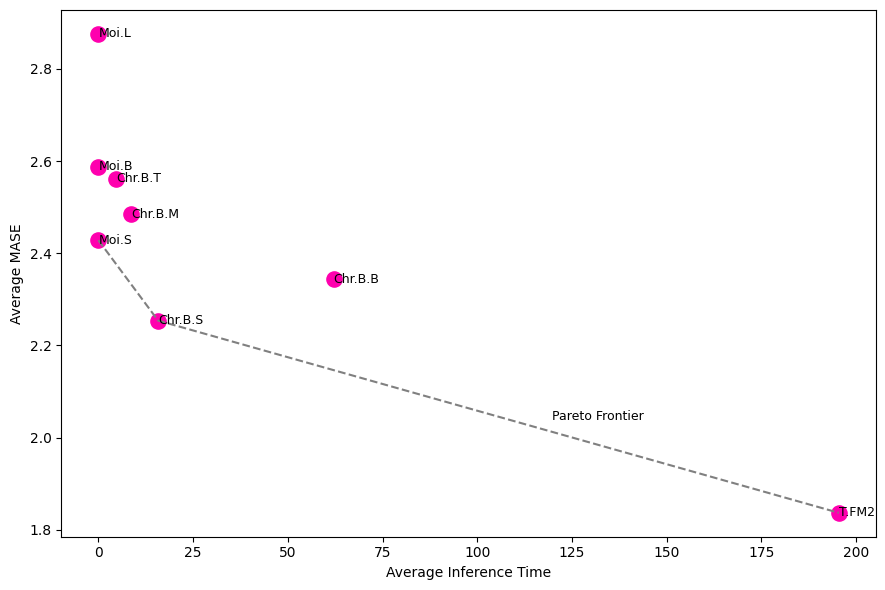

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric = "MASE"
avg_data = plot_df.groupby("model")[["time", metric]].mean().reset_index()
avg_data = avg_data[avg_data["model"] != "T.FM1"]

# Ordina per tempo crescente
avg_data_sorted = avg_data.sort_values(by="time")

# Trova la Pareto frontier (modelli non dominati)
pareto_points = []
current_best_metric = np.inf
for _, row in avg_data_sorted.iterrows():
    if row[metric] < current_best_metric:
        pareto_points.append(row)
        current_best_metric = row[metric]
pareto_df = pd.DataFrame(pareto_points).reset_index()

plt.figure(figsize=(9, 6))

# Pareto frontier
plt.plot(pareto_df["time"], pareto_df[metric], color="gray", linestyle="--", linewidth=1.5,
    label="Pareto Frontier")
plt.text((pareto_df["time"][2] - pareto_df["time"][1])/3*2,
    (pareto_df[metric][1] - pareto_df[metric][2])/2 + pareto_df[metric][2],
    "Pareto Frontier", fontsize=9, ha="left", va="center", alpha=1)

# Plot
for _, row in avg_data.iterrows():
    plt.scatter(row["time"], row[metric], color="#fe00ae", s=120, label=row["model"])
    plt.text(row["time"], row[metric], row["model"], fontsize=9,
        ha="left", va="center", alpha=1)

plt.xlabel("Average Inference Time")
plt.ylabel(f"Average {metric}")
#plt.title(f"Average {metric} vs Average Inference Time per Model")
#plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig(f"figures/pareto_plot_MASE.pdf")
plt.show()

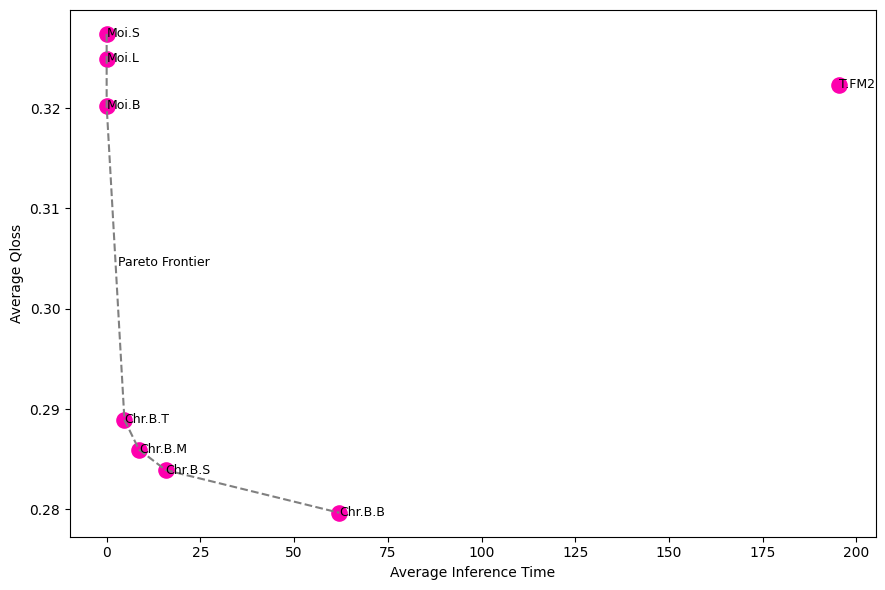

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

metric = "Qloss"
avg_data = plot_df.groupby("model")[["time", metric]].mean().reset_index()
avg_data = avg_data[avg_data["model"] != "T.FM1"]

# Ordina per tempo crescente
avg_data_sorted = avg_data.sort_values(by="time")

# Trova la Pareto frontier (modelli non dominati)
pareto_points = []
current_best_metric = np.inf
for _, row in avg_data_sorted.iterrows():
    if row[metric] < current_best_metric:
        pareto_points.append(row)
        current_best_metric = row[metric]
pareto_df = pd.DataFrame(pareto_points).reset_index()

plt.figure(figsize=(9, 6))

# Pareto frontier
plt.plot(pareto_df["time"], pareto_df[metric], color="gray", linestyle="--", linewidth=1.5,
    label="Pareto Frontier")
plt.text((pareto_df["time"][2] - pareto_df["time"][1])/3*2,
    (pareto_df[metric][1] - pareto_df[metric][2])/2 + pareto_df[metric][2],
    "Pareto Frontier", fontsize=9, ha="left", va="center", alpha=1)

# Plot
for _, row in avg_data.iterrows():
    plt.scatter(row["time"], row[metric], color="#fe00ae", s=120, label=row["model"])
    plt.text(row["time"], row[metric], row["model"], fontsize=9,
        ha="left", va="center", alpha=1)

plt.xlabel("Average Inference Time")
plt.ylabel(f"Average {metric}")
#plt.title(f"Average {metric} vs Average Inference Time per Model")
#plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.savefig(f"figures/pareto_plot_Qloss.pdf")
plt.show()

In [61]:
MODEL_PARAMETERS = {
    'Chr.B.B': 205000000,
    'Chr.B.S': 48000000,
    'Chr.B.M': 21000000,
    'Chr.B.T': 9000000,
    'T.FM1': 200000000,
    'T.FM2': 500000000,
    'Moi.S': 14000000,
    'Moi.B': 91000000,
    'Moi.L': 311000000,
}

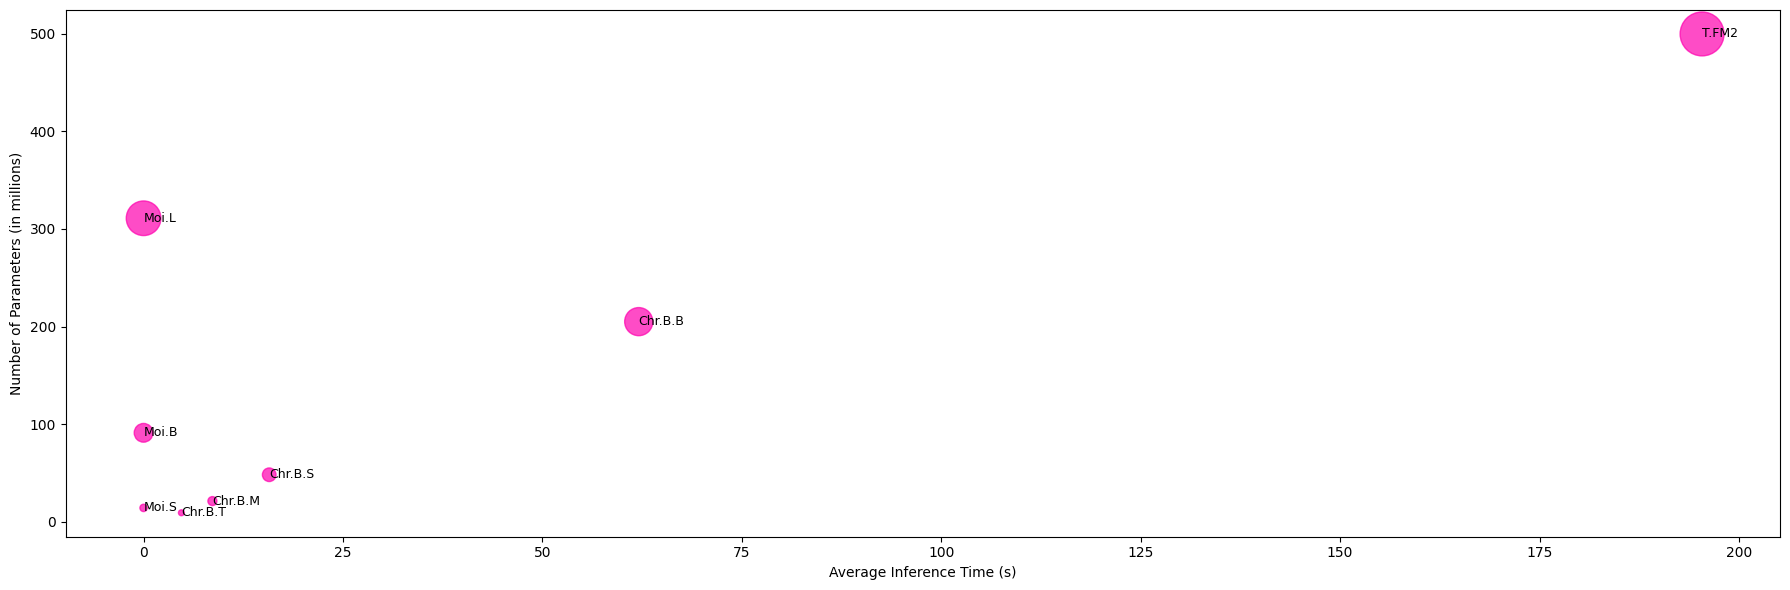

In [76]:
# plot time vs number of parameters
plt.figure(figsize=(18, 6))

# dot size proportional to number of parameters
avg_data["size"] = avg_data["model"].map(MODEL_PARAMETERS) * 2
plt.scatter(
    avg_data["time"],
    # number of parameters
    [MODEL_PARAMETERS[m] / 1000000 for m in avg_data["model"]],
    color="#fe00ae",
    s=avg_data["size"] / 1000000,  # scale down for better visibility
    alpha=0.7
)
for _, row in avg_data.iterrows():
    plt.text(row["time"], MODEL_PARAMETERS[row["model"]] / 1000000,
             row["model"], fontsize=9, ha="left", va="center", alpha=1)
#plt.xscale("log")
#plt.yscale("log")

plt.xlabel("Average Inference Time (s)")
plt.ylabel("Number of Parameters (in millions)")#\n" \"Logarithmic Scale")
#plt.title("Average Inference Time vs Number of Parameters per Model")
plt.tight_layout()

plt.savefig(f"figures/inference_time_vs_parameters.pdf")
plt.show()